# Set up

In [7]:
import os
import pandas as pd
import numpy as np
from collections import Counter
import demjson
import json
import sys
from Bio import SeqIO

In [8]:
import re

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
def translate(seq):
     
    table = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',                
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
    }
    protein =""
    #print(seq)
    if len(seq)%3 == 0:
        for i in range(0, len(seq), 3):
            codon = seq[i:i + 3]
            if codon in table.keys():
                protein+= table[codon]
            else:
                protein+= '_'
    elif len(seq)%3 == 1:
        for i in range(0, len(seq)-1, 3):
            codon = seq[i:i + 3]
            if codon in table.keys():
                protein+= table[codon]
            else:
                protein+= '_'
    elif len(seq)%3 == 2:
        for i in range(0, len(seq)-2, 3):
            codon = seq[i:i + 3]
            if codon in table.keys():
                protein+= table[codon]
            else:
                protein+= '_'
    return protein


In [11]:
def read_igblast_fileA(file):
    with open(file) as f:
        lines = f.readlines()
    if len(lines)>60:
        chunks = []
        chunk_index = []
        junction_index = []
        vj_index = []
        for i in range(len(lines)):
            line = lines[i]
            if 'but are not included under the V, D, or J gene itself' in line:
                junction_index.append( i )

            if 'V-(D)-J rearrangement summary' in line:
                vj_index.append(i)


            if line.startswith("Alignments"):
                # begin chunks
                begin_index = i+1

            if line.startswith("Lambda"):
                # end chunk
                end_index = i-1

                chunk_index.append((begin_index, end_index))

        chunk_index_ = []
        for i in range(0,len(chunk_index),2):
            chunk_index_.append(chunk_index[i])

        chunk_index = chunk_index_

        chunks = list(map(lambda x: ''.join(lines[x[0]:x[1]]), chunk_index))

        cdr3s = []
        for chunk in chunks:
            imgt_annotations = ''
            amino_acids = ''
            flag = False
            if 'FR3-IMGT' in chunk:
                chunk = chunk.split("\n\n")
                for c in chunk:
                    if ''.join(c) == '' or 'Gapped' in ''.join(c):
                        continue
                    c = c.split("\n")
                    if not flag:
                        imgt_annotation = c[1].strip(" ")
                        amino_acid = c[2].strip(" ")
                        flag = True 
                    else:
                        imgt_annotation = c[0].strip(" ")
                        amino_acid = c[1].strip(" ")     
                    imgt_annotations += imgt_annotation
                    amino_acids += " " + amino_acid + " "
            amino_acids = amino_acids.split("Lambda")[0]
            cdr3 = amino_acids[len(imgt_annotations)-2:].replace(" ", "")
            cdr3s.append(cdr3)
        chunk_ids = list(map(lambda x: lines[x+1].replace("\t","").replace("N/A","").strip(), junction_index))

        vj_genes = list(map(lambda x: lines[x+1].split("\t")[:2], vj_index))

        result = list(zip(vj_genes, cdr3s))
    elif len(lines)<=60:
        cdr3s=["None"]
        vj_genes=["None","None"]
        result = list(zip(vj_genes, cdr3s))
    return result

In [12]:
def read_igblast_fileB(file):
    with open(file) as f:
        lines = f.readlines()
    if len(lines)>60:
        chunks = []
        chunk_index = []
        junction_index = []
        vj_index = []
        for i in range(len(lines)):
            line = lines[i]
            if 'but are not included under the V, D, or J gene itself' in line:
                junction_index.append( i )

            if 'V-(D)-J rearrangement summary' in line:
                vj_index.append(i)


            if line.startswith("Alignments"):
                # begin chunks
                begin_index = i+1

            if line.startswith("Lambda"):
                # end chunk
                end_index = i-1

                chunk_index.append((begin_index, end_index))

        chunk_index_ = []
        for i in range(0,len(chunk_index),2):
            chunk_index_.append(chunk_index[i])

        chunk_index = chunk_index_

        chunks = list(map(lambda x: ''.join(lines[x[0]:x[1]]), chunk_index))

        cdr3s = []
        for chunk in chunks:
            imgt_annotations = ''
            amino_acids = ''
            flag = False
            if 'FR3-IMGT' in chunk:
                chunk = chunk.split("\n\n")
                for c in chunk:
                    if ''.join(c) == '' or 'Gapped' in ''.join(c):
                        continue
                    c = c.split("\n")
                    if not flag:
                        imgt_annotation = c[1].strip(" ")
                        amino_acid = c[2].strip(" ")
                        flag = True 
                    else:
                        imgt_annotation = c[0].strip(" ")
                        amino_acid = c[1].strip(" ")     
                    imgt_annotations += imgt_annotation
                    amino_acids += " " + amino_acid + " "
            amino_acids = amino_acids.split("Lambda")[0]
            cdr3 = amino_acids[len(imgt_annotations)-2:].replace(" ", "")
            cdr3s.append(cdr3)
        chunk_ids = list(map(lambda x: lines[x+1].replace("\t","").replace("N/A","").strip(), junction_index))

        vj_genes = list(map(lambda x: [lines[x+1].split("\t")[0],lines[x+1].split("\t")[2]], vj_index))

        result = list(zip(vj_genes, cdr3s))
    elif len(lines)<=60:
        cdr3s=["None"]
        vj_genes=["None","None"]
        result = list(zip(vj_genes, cdr3s))
    return result

# For different length

In [13]:
reads_legth_ls=["50","100","150","250"]

In [14]:
ground_truth_filedir="./Simulation_results/data_dl2"

In [15]:
cellbarcode_ls=list(pd.read_csv("./Simulation_results/cellbarcode_list.txt",header=None)[0])

# percision json

## For different length

### TRUST4

In [16]:
trsut4_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/01_trust4_fq"

In [17]:
results_json=[]
for i in reads_legth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        cdr3_file_path=trsut4_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+"_cdr3.out"
        dict_tmp['cellbarcode']=cellbarcode
        dict_tmp['reads_length']=i
        if os.path.getsize(cdr3_file_path)==0:
            dict_tmp['TRA_J_gene']=None
            dict_tmp['TRA_J_gene_number']=0
            dict_tmp['TRA_V_gene']=None
            dict_tmp['TRA_V_gene_number']=0
            dict_tmp['TRA_CDR3']=None
            dict_tmp['TRA_CDR3_AA']=None
            dict_tmp['TRA_CDR3_number']=0
            dict_tmp['TRB_J_gene']=None
            dict_tmp['TRB_J_gene_number']=0
            dict_tmp['TRB_V_gene']=None
            dict_tmp['TRB_V_gene_number']=0
            dict_tmp['TRB_CDR3']=None
            dict_tmp['TRB_CDR3_AA']=None
            dict_tmp['TRB_CDR3_number']=0
        else:
            cdr3_df=pd.read_table(cdr3_file_path,header=None)
            cdr3_df['chaintype_isTRB']=list(map(lambda x: "TRB" in ''.join(cdr3_df.iloc[x,2:5]),range(0,cdr3_df.shape[0])))
            cdr3_df['chaintype_isTRA']=list(map(lambda x: "TRA" in ''.join(cdr3_df.iloc[x,2:5]),range(0,cdr3_df.shape[0])))
            cdr3_TRB_df=cdr3_df[cdr3_df.chaintype_isTRB==True]
            cdr3_TRA_df=cdr3_df[cdr3_df.chaintype_isTRA==True]
            dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.iloc[:,4])
            dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.iloc[:,4]))
            dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.iloc[:,2])
            dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.iloc[:,2]))
            dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.iloc[:,8])
            dict_tmp['TRA_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRA_df.iloc[:,8])))
            dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.iloc[:,8]))
            dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.iloc[:,4])
            dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.iloc[:,4]))
            dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.iloc[:,2])
            dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.iloc[:,2]))
            dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.iloc[:,8])
            dict_tmp['TRB_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRB_df.iloc[:,8])))
            dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.iloc[:,8]))
        results_json.append(dict_tmp)

In [18]:
f=open("./Simulation_results/data/trust4_results_length.json",'w')
f.write(json.dumps(results_json))
f.close()  

### MiXCR

In [19]:
mixcr_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/02_mixcr_fq"

In [20]:
results_json=[]
for i in reads_legth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_length']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3A_file_path=mixcr_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+".clonotypes.TRA.txt"
        cdr3B_file_path=mixcr_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+".clonotypes.TRB.txt"
        if os.path.isfile(cdr3A_file_path):
            cdr3_TRA_df=pd.read_table(cdr3A_file_path)
            cdr3_TRB_df=pd.read_table(cdr3B_file_path)
            if cdr3_TRA_df.shape[0]==0:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0
            else:
                dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.allVHitsWithScore)
                dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.allVHitsWithScore))
                dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.allJHitsWithScore)
                dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.allJHitsWithScore))
                dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.targetSequences)
                dict_tmp['TRA_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRA_df.targetSequences)))
                dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.targetSequences))
            if cdr3_TRB_df.shape[0]==0:
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0
            else:
                dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.allVHitsWithScore)
                dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.allVHitsWithScore))
                dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.allJHitsWithScore)
                dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.allJHitsWithScore))
                dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.targetSequences)
                dict_tmp['TRB_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRB_df.targetSequences)))
                dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.targetSequences))
        results_json.append(dict_tmp)

In [21]:
f=open("./Simulation_results/data/mixcr_results_length.json",'w')
f.write(json.dumps(results_json))
f.close()  

### TraCeR

In [22]:
tracer_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/05_tracer_fq"

In [23]:
results_json=[]
for i in reads_legth_ls:
    merge_for_sample_df=pd.DataFrame()
    for cellbarcode in cellbarcode_ls:
        fileA=tracer_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+"/IgBLAST_output/"+cellbarcode+"_TCR_A_fmt3.IgBLASTOut"
        if os.path.exists(fileA):
            try:
                A_tmp_df=pd.DataFrame(read_igblast_fileA(fileA))
            except:
                A_tmp_df=pd.DataFrame({
                    "0":["None"],
                    "1":["None"]
                })
            A_tmp_df.columns=["genes","CDR3_AA"]
            A_new_V_list = [] 
            for lst in A_tmp_df.genes.values: 
                if len(lst) > 0: 
                    A_new_V_list.append(lst[0])
            A_new_J_list = [] 
            for lst in A_tmp_df.genes.values: 
                if len(lst) > 0: 
                    A_new_J_list.append(lst[1])
            A_tmp_df["cell_barcode"]=cellbarcode
            A_tmp_df["chaintype"]="TRA"
            A_tmp_df["V_gene"]=A_new_V_list
            A_tmp_df["J_gene"]=A_new_J_list
        else:
            A_tmp_df=pd.DataFrame(columns=["genes","CDR3_AA",
                                           "cell_barcode","chaintype",
                                          "V_gene","J_gene"])
        fileB=tracer_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+"/IgBLAST_output/"+cellbarcode+"_TCR_B_fmt3.IgBLASTOut"
        if os.path.exists(fileB): 
            try:
                B_tmp_df=pd.DataFrame(read_igblast_fileB(fileB))
            except:
                B_tmp_df=pd.DataFrame({
                    "0":["None"],
                    "1":["None"]
                })
            B_tmp_df.columns=["genes","CDR3_AA"]
            B_new_V_list = [] 
            for lst in B_tmp_df.genes.values: 
                if len(lst) > 0: 
                    B_new_V_list.append(lst[0])
            B_new_J_list = [] 
            for lst in B_tmp_df.genes.values: 
                if len(lst) > 0: 
                    B_new_J_list.append(lst[1])
            B_tmp_df["cell_barcode"]=cellbarcode
            B_tmp_df["chaintype"]="TRB"
            B_tmp_df["V_gene"]=B_new_V_list
            B_tmp_df["J_gene"]=B_new_J_list
        else:
            B_tmp_df=pd.DataFrame(columns=["genes","CDR3_AA",
                                           "cell_barcode","chaintype",
                                          "V_gene","J_gene"])
        dict_tmp={}
        dict_tmp['reads_length']=i
        dict_tmp['cellbarcode']=cellbarcode
        A_J_gene_list=list({gene.split('*')[0] for gene in list(A_tmp_df['J_gene'])})
        dict_tmp['TRA_J_gene']=A_J_gene_list
        dict_tmp['TRA_J_gene_number']=len(A_J_gene_list)
        A_V_gene_list=list({gene.split('*')[0] for gene in list(A_tmp_df['V_gene'])})
        dict_tmp['TRA_V_gene']=A_V_gene_list
        dict_tmp['TRA_V_gene_number']=len(A_V_gene_list)
        dict_tmp['TRA_CDR3']=list(A_tmp_df['CDR3_AA'])
        dict_tmp['TRA_CDR3_AA']=list(A_tmp_df['CDR3_AA'])
        dict_tmp['TRA_CDR3_number']=len(list(A_tmp_df['CDR3_AA']))
        B_J_gene_list=list({gene.split('*')[0] for gene in list(B_tmp_df['J_gene'])})
        dict_tmp['TRB_J_gene']=B_J_gene_list
        dict_tmp['TRB_J_gene_number']=len(B_J_gene_list)
        B_V_gene_list=list({gene.split('*')[0] for gene in list(B_tmp_df['V_gene'])})
        dict_tmp['TRB_V_gene']=B_V_gene_list
        dict_tmp['TRB_V_gene_number']=len(B_V_gene_list)
        dict_tmp['TRB_CDR3']=list(B_tmp_df['CDR3_AA'])
        dict_tmp['TRB_CDR3_AA']=list(B_tmp_df['CDR3_AA'])
        dict_tmp['TRB_CDR3_number']=len(list(B_tmp_df['CDR3_AA']))
        results_json.append(dict_tmp)      

In [24]:
f=open("./Simulation_results/data/tracer_results_length.json",'w')
f.write(json.dumps(results_json))
f.close()  

### ImRep

In [25]:
imrep_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/06_imrep_fq"

In [26]:
results_json=[]
for i in reads_legth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_length']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3_file_path=imrep_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+".cdr3"
        if os.path.isfile(cdr3_file_path):
            cdr3_df=pd.read_table(cdr3_file_path,sep=",")
            if cdr3_df.shape[0]==0:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0            
            else:
                cdr3_TRA_df=cdr3_df[cdr3_df.Chain_type=="TRA"]
                cdr3_TRB_df=cdr3_df[cdr3_df.Chain_type=="TRB"]
                dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.J_chains)
                dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.J_chains))
                dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.V_chains)
                dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.V_chains))
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=list(cdr3_TRA_df.CDR3_AA_Seq)
                dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.CDR3_AA_Seq))
                dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.J_chains)
                dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.J_chains))
                dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.V_chains)
                dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.V_chains))
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=list(cdr3_TRB_df.CDR3_AA_Seq)
                dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.CDR3_AA_Seq)) 
        results_json.append(dict_tmp)

In [27]:
f=open("./Simulation_results/data/imrep_results_length.json",'w')
f.write(json.dumps(results_json))
f.close()  

### CATT

In [28]:
catt_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/07_catt_fq"

In [29]:
results_json=[]
for i in reads_legth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_length']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3A_file_path=catt_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+".TRA.CDR3.CATT.csv"
        cdr3B_file_path=catt_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+".TRB.CDR3.CATT.csv"
        if os.path.isfile(cdr3A_file_path):
            if os.path.getsize(cdr3A_file_path)!=int(0):
                cdr3_TRA_df=pd.read_table(cdr3A_file_path,sep=",")
                if cdr3_TRA_df.shape[0]==0:
                    dict_tmp['TRA_J_gene']=None
                    dict_tmp['TRA_J_gene_number']=0
                    dict_tmp['TRA_V_gene']=None
                    dict_tmp['TRA_V_gene_number']=0
                    dict_tmp['TRA_CDR3']=None
                    dict_tmp['TRA_CDR3_AA']=None
                    dict_tmp['TRA_CDR3_number']=0
                else:
                    dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.Jregion)
                    dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.Jregion))
                    dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.Vregion)
                    dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.Vregion))
                    dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.NNseq)
                    dict_tmp['TRA_CDR3_AA']=list(cdr3_TRA_df.AAseq)
                    dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.AAseq))
            else:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0                
        else:
            dict_tmp['TRA_J_gene']=None
            dict_tmp['TRA_J_gene_number']=0
            dict_tmp['TRA_V_gene']=None
            dict_tmp['TRA_V_gene_number']=0
            dict_tmp['TRA_CDR3']=None
            dict_tmp['TRA_CDR3_AA']=None
            dict_tmp['TRA_CDR3_number']=0
        if os.path.isfile(cdr3B_file_path):
            if os.path.getsize(cdr3B_file_path)!=int(0):
                cdr3_TRB_df=pd.read_table(cdr3B_file_path,sep=",")
                if cdr3_TRB_df.shape[0]==0:
                    dict_tmp['TRB_J_gene']=None
                    dict_tmp['TRB_J_gene_number']=0
                    dict_tmp['TRB_V_gene']=None
                    dict_tmp['TRB_V_gene_number']=0
                    dict_tmp['TRB_CDR3']=None
                    dict_tmp['TRB_CDR3_AA']=None
                    dict_tmp['TRB_CDR3_number']=0 
                else:
                    dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.Jregion)
                    dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.Jregion))
                    dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.Vregion)
                    dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.Vregion))
                    dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.NNseq)
                    dict_tmp['TRB_CDR3_AA']=list(cdr3_TRB_df.AAseq)
                    dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.AAseq))
            else:
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0                
        else:
            dict_tmp['TRB_J_gene']=None
            dict_tmp['TRB_J_gene_number']=0
            dict_tmp['TRB_V_gene']=None
            dict_tmp['TRB_V_gene_number']=0
            dict_tmp['TRB_CDR3']=None
            dict_tmp['TRB_CDR3_AA']=None
            dict_tmp['TRB_CDR3_number']=0 
        results_json.append(dict_tmp)

In [30]:
f=open("./Simulation_results/data/catt_results_length.json",'w')
f.write(json.dumps(results_json))
f.close() 

### DeRR

In [31]:
derr_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/08_derr_fq"

In [32]:
results_json=[]
for i in reads_legth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_length']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3_file_path=derr_filedir+"/01_fq_output_length/"+i+"/"+cellbarcode+"_results.tsv"
        if os.path.isfile(cdr3_file_path):
            cdr3_df=pd.read_table(cdr3_file_path,sep="\t")
            if cdr3_df.shape[0]==0:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0 
            else:
                cdr3_TRA_df=cdr3_df[cdr3_df.Chain=="TRA"]
                cdr3_TRB_df=cdr3_df[cdr3_df.Chain=="TRB"]
                dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.Jgene)
                dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.Jgene))
                dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.Vgene)
                dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.Vgene))
                dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.CDR3nn)
                dict_tmp['TRA_CDR3_AA']=list(cdr3_TRA_df.CDR3)
                dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.CDR3))
                dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.Jgene)
                dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.Jgene))
                dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.Vgene)
                dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.Vgene))
                dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.CDR3nn)
                dict_tmp['TRB_CDR3_AA']=list(cdr3_TRB_df.CDR3)
                dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.CDR3))
        results_json.append(dict_tmp)

In [33]:
f=open("./Simulation_results/data/derr_results_length.json",'w')
f.write(json.dumps(results_json))
f.close() 

## For different depth

In [34]:
reads_depth_ls=["2","4","6","8","10","20","40","60","80","100"]

### TRUST4

In [35]:
trsut4_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/01_trust4_fq"

In [36]:
results_json=[]
for i in reads_depth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        cdr3_file_path=trsut4_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+"_cdr3.out"
        dict_tmp['cellbarcode']=cellbarcode
        dict_tmp['reads_depth']=i
        if os.path.getsize(cdr3_file_path)==0:
            dict_tmp['TRA_J_gene']=None
            dict_tmp['TRA_J_gene_number']=0
            dict_tmp['TRA_V_gene']=None
            dict_tmp['TRA_V_gene_number']=0
            dict_tmp['TRA_CDR3']=None
            dict_tmp['TRA_CDR3_AA']=None
            dict_tmp['TRA_CDR3_number']=0
            dict_tmp['TRB_J_gene']=None
            dict_tmp['TRB_J_gene_number']=0
            dict_tmp['TRB_V_gene']=None
            dict_tmp['TRB_V_gene_number']=0
            dict_tmp['TRB_CDR3']=None
            dict_tmp['TRB_CDR3_AA']=None
            dict_tmp['TRB_CDR3_number']=0
        else:
            cdr3_df=pd.read_table(cdr3_file_path,header=None)
            cdr3_df['chaintype_isTRB']=list(map(lambda x: "TRB" in ''.join(cdr3_df.iloc[x,2:5]),range(0,cdr3_df.shape[0])))
            cdr3_df['chaintype_isTRA']=list(map(lambda x: "TRA" in ''.join(cdr3_df.iloc[x,2:5]),range(0,cdr3_df.shape[0])))
            cdr3_TRB_df=cdr3_df[cdr3_df.chaintype_isTRB==True]
            cdr3_TRA_df=cdr3_df[cdr3_df.chaintype_isTRA==True]
            dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.iloc[:,4])
            dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.iloc[:,4]))
            dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.iloc[:,2])
            dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.iloc[:,2]))
            dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.iloc[:,8])
            dict_tmp['TRA_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRA_df.iloc[:,8])))
            dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.iloc[:,8]))
            dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.iloc[:,4])
            dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.iloc[:,4]))
            dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.iloc[:,2])
            dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.iloc[:,2]))
            dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.iloc[:,8])
            dict_tmp['TRB_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRB_df.iloc[:,8])))
            dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.iloc[:,8]))
        results_json.append(dict_tmp)

In [37]:
f=open("./Simulation_results/data/trust4_results_depth.json",'w')
f.write(json.dumps(results_json))
f.close()  

### MiXCR

In [38]:
mixcr_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/02_mixcr_fq"

In [39]:
results_json=[]
for i in reads_depth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_depth']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3A_file_path=mixcr_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+".clonotypes.TRA.txt"
        cdr3B_file_path=mixcr_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+".clonotypes.TRB.txt"
        #print(cdr3A_file_path)
        #print(cdr3B_file_path)
        if os.path.isfile(cdr3A_file_path):
            cdr3_TRA_df=pd.read_table(cdr3A_file_path)
            cdr3_TRB_df=pd.read_table(cdr3B_file_path)
            if cdr3_TRA_df.shape[0]==0:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0
            else:
                dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.allVHitsWithScore)
                dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.allVHitsWithScore))
                dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.allJHitsWithScore)
                dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.allJHitsWithScore))
                dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.targetSequences)
                dict_tmp['TRA_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRA_df.targetSequences)))
                dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.targetSequences))
            if cdr3_TRB_df.shape[0]==0:
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0
            else:
                dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.allVHitsWithScore)
                dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.allVHitsWithScore))
                dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.allJHitsWithScore)
                dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.allJHitsWithScore))
                dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.targetSequences)
                dict_tmp['TRB_CDR3_AA']=list(map(lambda x: translate(x),list(cdr3_TRB_df.targetSequences)))
                dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.targetSequences))
        results_json.append(dict_tmp)

In [40]:
f=open("./Simulation_results/data/mixcr_results_depth.json",'w')
f.write(json.dumps(results_json))
f.close()  

### TraCeR

In [41]:
tracer_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/05_tracer_fq"

In [42]:
results_json=[]
for i in reads_depth_ls:
    merge_for_sample_df=pd.DataFrame()
    for cellbarcode in cellbarcode_ls:
        fileA=tracer_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+"/IgBLAST_output/"+cellbarcode+"_TCR_A_fmt3.IgBLASTOut"
        if os.path.exists(fileA):
            try:
                A_tmp_df=pd.DataFrame(read_igblast_fileA(fileA))
            except:
                A_tmp_df=pd.DataFrame({
                    "0":["None"],
                    "1":["None"]
                })
            A_tmp_df.columns=["genes","CDR3_AA"]
            A_new_V_list = [] 
            for lst in A_tmp_df.genes.values: 
                if len(lst) > 0: 
                    A_new_V_list.append(lst[0])
            A_new_J_list = [] 
            for lst in A_tmp_df.genes.values: 
                if len(lst) > 0: 
                    A_new_J_list.append(lst[1])
            A_tmp_df["cell_barcode"]=cellbarcode
            A_tmp_df["chaintype"]="TRA"
            A_tmp_df["V_gene"]=A_new_V_list
            A_tmp_df["J_gene"]=A_new_J_list
        else:
            A_tmp_df=pd.DataFrame(columns=["genes","CDR3_AA",
                                           "cell_barcode","chaintype",
                                          "V_gene","J_gene"])
        fileB=tracer_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+"/IgBLAST_output/"+cellbarcode+"_TCR_B_fmt3.IgBLASTOut"
        if os.path.exists(fileB): 
            try:
                B_tmp_df=pd.DataFrame(read_igblast_fileB(fileB))
            except:
                B_tmp_df=pd.DataFrame({
                    "0":["None"],
                    "1":["None"]
                })
            B_tmp_df.columns=["genes","CDR3_AA"]
            B_new_V_list = [] 
            for lst in B_tmp_df.genes.values: 
                if len(lst) > 0: 
                    B_new_V_list.append(lst[0])
            B_new_J_list = [] 
            for lst in B_tmp_df.genes.values: 
                if len(lst) > 0: 
                    B_new_J_list.append(lst[1])
            B_tmp_df["cell_barcode"]=cellbarcode
            B_tmp_df["chaintype"]="TRB"
            B_tmp_df["V_gene"]=B_new_V_list
            B_tmp_df["J_gene"]=B_new_J_list
        else:
            B_tmp_df=pd.DataFrame(columns=["genes","CDR3_AA",
                                           "cell_barcode","chaintype",
                                          "V_gene","J_gene"])
        dict_tmp={}
        dict_tmp['reads_depth']=i
        dict_tmp['cellbarcode']=cellbarcode
        A_J_gene_list=list({gene.split('*')[0] for gene in list(A_tmp_df['J_gene'])})
        dict_tmp['TRA_J_gene']=A_J_gene_list
        dict_tmp['TRA_J_gene_number']=len(A_J_gene_list)
        A_V_gene_list=list({gene.split('*')[0] for gene in list(A_tmp_df['V_gene'])})
        dict_tmp['TRA_V_gene']=A_V_gene_list
        dict_tmp['TRA_V_gene_number']=len(A_V_gene_list)
        dict_tmp['TRA_CDR3']=list(A_tmp_df['CDR3_AA'])
        dict_tmp['TRA_CDR3_AA']=list(A_tmp_df['CDR3_AA'])
        dict_tmp['TRA_CDR3_number']=len(list(A_tmp_df['CDR3_AA']))
        B_J_gene_list=list({gene.split('*')[0] for gene in list(B_tmp_df['J_gene'])})
        dict_tmp['TRB_J_gene']=B_J_gene_list
        dict_tmp['TRB_J_gene_number']=len(B_J_gene_list)
        B_V_gene_list=list({gene.split('*')[0] for gene in list(B_tmp_df['V_gene'])})
        dict_tmp['TRB_V_gene']=B_V_gene_list
        dict_tmp['TRB_V_gene_number']=len(B_V_gene_list)
        dict_tmp['TRB_CDR3']=list(B_tmp_df['CDR3_AA'])
        dict_tmp['TRB_CDR3_AA']=list(B_tmp_df['CDR3_AA'])
        dict_tmp['TRB_CDR3_number']=len(list(B_tmp_df['CDR3_AA']))
        results_json.append(dict_tmp)      

In [43]:
f=open("./Simulation_results/data/tracer_results_depth.json",'w')
f.write(json.dumps(results_json))
f.close()  

### ImRep

In [44]:
imrep_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/06_imrep_fq"

In [45]:
results_json=[]
for i in reads_depth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_depth']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3_file_path=imrep_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+".cdr3"
        if os.path.isfile(cdr3_file_path):
            cdr3_df=pd.read_table(cdr3_file_path,sep=",")
            if cdr3_df.shape[0]==0:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0            
            else:
                cdr3_TRA_df=cdr3_df[cdr3_df.Chain_type=="TRA"]
                cdr3_TRB_df=cdr3_df[cdr3_df.Chain_type=="TRB"]
                dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.J_chains)
                dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.J_chains))
                dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.V_chains)
                dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.V_chains))
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=list(cdr3_TRA_df.CDR3_AA_Seq)
                dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.CDR3_AA_Seq))
                dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.J_chains)
                dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.J_chains))
                dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.V_chains)
                dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.V_chains))
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=list(cdr3_TRB_df.CDR3_AA_Seq)
                dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.CDR3_AA_Seq)) 
        results_json.append(dict_tmp)

In [46]:
f=open("./Simulation_results/data/imrep_results_depth.json",'w')
f.write(json.dumps(results_json))
f.close()  

### CATT

In [47]:
catt_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/07_catt_fq"

In [48]:
results_json=[]
for i in reads_depth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_depth']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3A_file_path=catt_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+".TRA.CDR3.CATT.csv"
        cdr3B_file_path=catt_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+".TRB.CDR3.CATT.csv"
        if os.path.isfile(cdr3A_file_path):
            if os.path.getsize(cdr3A_file_path)!=int(0):
                cdr3_TRA_df=pd.read_table(cdr3A_file_path,sep=",")
                if cdr3_TRA_df.shape[0]==0:
                    dict_tmp['TRA_J_gene']=None
                    dict_tmp['TRA_J_gene_number']=0
                    dict_tmp['TRA_V_gene']=None
                    dict_tmp['TRA_V_gene_number']=0
                    dict_tmp['TRA_CDR3']=None
                    dict_tmp['TRA_CDR3_AA']=None
                    dict_tmp['TRA_CDR3_number']=0
                else:
                    dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.Jregion)
                    dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.Jregion))
                    dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.Vregion)
                    dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.Vregion))
                    dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.NNseq)
                    dict_tmp['TRA_CDR3_AA']=list(cdr3_TRA_df.AAseq)
                    dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.AAseq))
            else:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0                
        else:
            dict_tmp['TRA_J_gene']=None
            dict_tmp['TRA_J_gene_number']=0
            dict_tmp['TRA_V_gene']=None
            dict_tmp['TRA_V_gene_number']=0
            dict_tmp['TRA_CDR3']=None
            dict_tmp['TRA_CDR3_AA']=None
            dict_tmp['TRA_CDR3_number']=0
        if os.path.isfile(cdr3B_file_path):
            if os.path.getsize(cdr3B_file_path)!=int(0):
                cdr3_TRB_df=pd.read_table(cdr3B_file_path,sep=",")
                if cdr3_TRB_df.shape[0]==0:
                    dict_tmp['TRB_J_gene']=None
                    dict_tmp['TRB_J_gene_number']=0
                    dict_tmp['TRB_V_gene']=None
                    dict_tmp['TRB_V_gene_number']=0
                    dict_tmp['TRB_CDR3']=None
                    dict_tmp['TRB_CDR3_AA']=None
                    dict_tmp['TRB_CDR3_number']=0 
                else:
                    dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.Jregion)
                    dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.Jregion))
                    dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.Vregion)
                    dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.Vregion))
                    dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.NNseq)
                    dict_tmp['TRB_CDR3_AA']=list(cdr3_TRB_df.AAseq)
                    dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.AAseq))
            else:
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0                
        else:
            dict_tmp['TRB_J_gene']=None
            dict_tmp['TRB_J_gene_number']=0
            dict_tmp['TRB_V_gene']=None
            dict_tmp['TRB_V_gene_number']=0
            dict_tmp['TRB_CDR3']=None
            dict_tmp['TRB_CDR3_AA']=None
            dict_tmp['TRB_CDR3_number']=0 
        results_json.append(dict_tmp)

In [49]:
f=open("./Simulation_results/data/catt_results_depth.json",'w')
f.write(json.dumps(results_json))
f.close() 

### DeRR

In [50]:
derr_filedir="/mnt/volume2/trn/04_benchmark/16_TCRseq_mixed/08_derr_fq"

In [51]:
results_json=[]
for i in reads_depth_ls:
    for cellbarcode in cellbarcode_ls:
        dict_tmp={}
        dict_tmp['reads_depth']=i
        dict_tmp['cellbarcode']=cellbarcode
        cdr3_file_path=derr_filedir+"/01_fq_output_depth/"+i+"/"+cellbarcode+"_results.tsv"
        if os.path.isfile(cdr3_file_path):
            cdr3_df=pd.read_table(cdr3_file_path,sep="\t")
            if cdr3_df.shape[0]==0:
                dict_tmp['TRA_J_gene']=None
                dict_tmp['TRA_J_gene_number']=0
                dict_tmp['TRA_V_gene']=None
                dict_tmp['TRA_V_gene_number']=0
                dict_tmp['TRA_CDR3']=None
                dict_tmp['TRA_CDR3_AA']=None
                dict_tmp['TRA_CDR3_number']=0
                dict_tmp['TRB_J_gene']=None
                dict_tmp['TRB_J_gene_number']=0
                dict_tmp['TRB_V_gene']=None
                dict_tmp['TRB_V_gene_number']=0
                dict_tmp['TRB_CDR3']=None
                dict_tmp['TRB_CDR3_AA']=None
                dict_tmp['TRB_CDR3_number']=0 
            else:
                cdr3_TRA_df=cdr3_df[cdr3_df.Chain=="TRA"]
                cdr3_TRB_df=cdr3_df[cdr3_df.Chain=="TRB"]
                dict_tmp['TRA_J_gene']=list(cdr3_TRA_df.Jgene)
                dict_tmp['TRA_J_gene_number']=len(list(cdr3_TRA_df.Jgene))
                dict_tmp['TRA_V_gene']=list(cdr3_TRA_df.Vgene)
                dict_tmp['TRA_V_gene_number']=len(list(cdr3_TRA_df.Vgene))
                dict_tmp['TRA_CDR3']=list(cdr3_TRA_df.CDR3nn)
                dict_tmp['TRA_CDR3_AA']=list(cdr3_TRA_df.CDR3)
                dict_tmp['TRA_CDR3_number']=len(list(cdr3_TRA_df.CDR3))
                dict_tmp['TRB_J_gene']=list(cdr3_TRB_df.Jgene)
                dict_tmp['TRB_J_gene_number']=len(list(cdr3_TRB_df.Jgene))
                dict_tmp['TRB_V_gene']=list(cdr3_TRB_df.Vgene)
                dict_tmp['TRB_V_gene_number']=len(list(cdr3_TRB_df.Vgene))
                dict_tmp['TRB_CDR3']=list(cdr3_TRB_df.CDR3nn)
                dict_tmp['TRB_CDR3_AA']=list(cdr3_TRB_df.CDR3)
                dict_tmp['TRB_CDR3_number']=len(list(cdr3_TRB_df.CDR3))
        results_json.append(dict_tmp)

In [52]:
f=open("./Simulation_results/data/derr_results_depth.json",'w')
f.write(json.dumps(results_json))
f.close() 

# json to csv

In [53]:
ground_truth_df=pd.read_table(ground_truth_filedir+"/sim_tcr.stats.tsv",sep="\t").applymap(lambda x: x.strip("'"))

In [54]:
def subsetjson(json,list):
    new_json=[]
    for tmp_json in json:
        if tmp_json['cellbarcode'] in list:
            new_json.append(tmp_json)
    return new_json

In [55]:
TRBJ_SEQUENCE = {
    'TRBJ1-1': 'NTEAFFGQGTRLTVV',
    'TRBJ1-2': 'NYGYTFGSGTRLTVV',
    'TRBJ1-3': 'SGNTIYFGEGSWLTVV',
    'TRBJ1-4': 'TNEKLFFGSGTQLSVL',
    'TRBJ1-5': 'SNQPQHFGDGTRLSIL',
    'TRBJ1-6': 'SYNSPLHFGNGTRLTVT',
    'TRBJ2-1': 'SYNEQFFGPGTRLTVL',
    'TRBJ2-2': 'NTGELFFGEGSRLTVL',
    'TRBJ2-3': 'STDTQYFGPGTRLTVL',
    'TRBJ2-4': 'AKTNIQYFGAGTRLSVL',
    'TRBJ2-5': 'QETQYFGPGTRLLVL',
    'TRBJ2-6': 'SGANVLTFGAGSRLTVL',
    'TRBJ2-7': 'SYEQYFGPGTRLTVT'
}


TRAJ_SEQUENCE = {
    'TRAJ1': 'YESITSQLQFGKGTRVSTSP',
    'TRAJ2': 'NTGGTIDKLTFGKGTHVFIIS',
    'TRAJ3': 'GYSSASKIIFGSGTRLSIRP',
    'TRAJ4': 'FSGGYNKLIFGAGTRLAVHP',
    'TRAJ5': 'DTGRRALTFGSGTRLQVQP',
    'TRAJ6': 'ASGGSYIPTFGRGTSLIVHP',
    'TRAJ7': 'DYGNNRLAFGKGNQVVVIP',
    'TRAJ8': 'NTGFQKLVFGTGTRLLVSP',
    'TRAJ9': 'GNTGGFKTIFGAGTRLFVKA',
    'TRAJ10': 'ILTGGGNKLTFGTGTQLKVEL',
    'TRAJ11': 'NSGYSTLTFGKGTMLLVSP',
    'TRAJ12': 'MDSSYKLIFGSGTRLLVRP',
    'TRAJ13': 'NSGGYQKVTFGIGTKLQVIP',
    'TRAJ14': 'IYSTFIFGSGTRLSVKP',
    'TRAJ15': 'NQAGTALIFGKGTTLSVSS',
    'TRAJ16': 'FSDGQKLLFARGTMLKVDL',
    'TRAJ17': 'IKAAGNKLTFGGGTRVLVKP',
    'TRAJ18': 'DRGSTLGRLYFGRGTQLTVWP',
    'TRAJ19': 'YQRFYNFTFGKGSKHNVTP',
    'TRAJ20': 'SNDYKLSFGAGTTVTVRA',
    'TRAJ21': 'YNFNKFYFGSGTKLNVKP',
    'TRAJ22': 'SSGSARQLTFGSGTQLTVLP',
    'TRAJ23': 'IYNQGGKLIFGQGTELSVKP',
    'TRAJ24': 'TTDSWGKFEFGAGTQVVVTP',
    'TRAJ25': 'EGQGFSFIFGKGTRLLVKP',
    'TRAJ26': 'DNYGQNFVFGPGTRLSVLP',
    'TRAJ27': 'NTNAGKSTFGDGTTLTVKP',
    'TRAJ28': 'YSGAGSYQLTFGKGTKLSVIP',
    'TRAJ29': 'NSGNTPLVFGKGTRLSVIA',
    'TRAJ30': 'NRDDKIIFGKGTRLHILP',
    'TRAJ31': 'NNNARLMFGDGTQLVVKP',
    'TRAJ32': 'NYGGATNKLIFGTGTLLAVQP',
    'TRAJ33': 'DSNYQLIWGAGTKLIIKP',
    'TRAJ34': 'SYNTDKLIFGTGTRLQVFP',
    'TRAJ35': 'IGFGNVLHCGSGTQVIVLP',
    'TRAJ36': 'QTGANNLFFGTGTRLTVIP',
    'TRAJ37': 'GSGNTGKLIFGQGTTLQVKP',
    'TRAJ38': 'NAGNNRKLIWGLGTSLAVNP',
    'TRAJ39': 'NNNAGNMLTFGGGTRLMVKP',
    'TRAJ40': 'TTSGTYKYIFGTGTRLKVLA',
    'TRAJ41': 'NSNSGYALNFGKGTSLLVTP',
    'TRAJ42': 'NYGGSQGNLIFGKGTKLSVKP',
    'TRAJ43': 'NNNDMRFGAGTRLTVKP',
    'TRAJ44': 'NTGTASKLTFGTGTRLQVTL',
    'TRAJ45': 'YSGGGADGLTFGKGTHLIIQP',
    'TRAJ46': 'KKSSGDKLTFGTGTRLAVRP',
    'TRAJ47': 'EYGNKLVFGAGTILRVKS',
    'TRAJ48': 'SNFGNEKLTFGTGTRLTIIP',
    'TRAJ49': 'NTGNQFYFGTGTSLTVIP',
    'TRAJ50': 'KTSYDKVIFGPGTSLSVIP',
    'TRAJ51': 'MRDSYEKLIFGKET*LTVKP',
    'TRAJ52': 'NAGGTSYGKLTFGQGTILTVHP',
    'TRAJ53': 'NSGGSNYKLTFGKGTLLTVNP',
    'TRAJ54': 'IQGAQKLVFGQGTRLTINP',
    'TRAJ55': 'KCW*CSCWGKGMSTKINP',
    'TRAJ56': 'YTGANSKLTFGKGITLSVRP',
    'TRAJ57': 'TQGGSEKLVFGKGTKLTVNP',
    'TRAJ58': 'ETSGSRLTFGEGTQLTVNP',
    'TRAJ59': 'KEGNRKFTFGMGTQVRVKL',
    'TRAJ60': 'KIT*MLNFGKGTELIVSL',
    'TRAJ61': 'YRVNRKLTFGANTRGIMKL',
}
TRAJ_SEQUENCE_END = {
    'TRAJ1': 'F',
    'TRAJ2': 'F',
    'TRAJ3': 'F',
    'TRAJ4': 'F',
    'TRAJ5': 'F',
    'TRAJ6': 'F',
    'TRAJ7': 'F',
    'TRAJ8': 'F',
    'TRAJ9': 'F',
    'TRAJ10': 'F',
    'TRAJ11': 'F',
    'TRAJ12': 'F',
    'TRAJ13': 'F',
    'TRAJ14': 'F',
    'TRAJ15': 'F',
    'TRAJ16': 'F',
    'TRAJ17': 'F',
    'TRAJ18': 'F',
    'TRAJ19': 'F',
    'TRAJ20': 'F',
    'TRAJ21': 'F',
    'TRAJ22': 'F',
    'TRAJ23': 'F',
    'TRAJ24': 'F',
    'TRAJ25': 'F',
    'TRAJ26': 'F',
    'TRAJ27': 'F',
    'TRAJ28': 'F',
    'TRAJ29': 'F',
    'TRAJ30': 'F',
    'TRAJ31': 'F',
    'TRAJ32': 'F',
    'TRAJ33': 'W',
    'TRAJ34': 'F',
    'TRAJ35': 'F',
    'TRAJ36': 'F',
    'TRAJ37': 'F',
    'TRAJ38': 'W',
    'TRAJ39': 'F',
    'TRAJ40': 'F',
    'TRAJ41': 'F',
    'TRAJ42': 'F',
    'TRAJ43': 'F',
    'TRAJ44': 'F',
    'TRAJ45': 'F',
    'TRAJ46': 'F',
    'TRAJ47': 'F',
    'TRAJ48': 'F',
    'TRAJ49': 'F',
    'TRAJ50': 'F',
    'TRAJ51': 'F',
    'TRAJ52': 'F',
    'TRAJ53': 'F',
    'TRAJ54': 'F',
    'TRAJ55': 'W',
    'TRAJ56': 'F',
    'TRAJ57': 'F',
    'TRAJ58': 'F',
    'TRAJ59': 'F',
    'TRAJ60': 'F',
    'TRAJ61': 'F',
}

def fill_up_alpha_cdr3(cdr3: str, j_gene: str):
    sequence_1 = TRAJ_SEQUENCE[j_gene]
    sequence_2 = cdr3
    end=TRAJ_SEQUENCE_END[j_gene]
    overlap = ''
    for n in range(len(sequence_1)):
        for i in range(1,n):
            if sequence_2.endswith(sequence_1[i-1:n-1]):
                overlap = sequence_1[i-1:n-1]
    #print(overlap)
    if not overlap:
        return cdr3
    return sequence_2 + sequence_1[sequence_1.index(overlap)+len(overlap):sequence_1.index(end)+1]
def fill_up_beta_cdr3(cdr3: str, j_gene: str):
    sequence_1 = TRBJ_SEQUENCE[j_gene]
    sequence_2 = cdr3
    overlap = ''
    for n in range(len(sequence_1)):
        for i in range(1,n):
            if sequence_2.endswith(sequence_1[i-1:n-1]):
                overlap = sequence_1[i-1:n-1]
    #print(overlap)
    if not overlap:
        return cdr3
    return sequence_2 + sequence_1[sequence_1.index(overlap)+len(overlap):sequence_1.index("F")+1]


In [56]:
def jsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    regex = r"\*(0[1-9])"
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_length']=dict_tmp['reads_length']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls = [re.sub(regex, '', x) for x in TRA_Vgene_ls_raw]
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            #print(TRA_Vgene_overlap)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls = [re.sub(regex, '', x) for x in TRB_Vgene_ls_raw]
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

## For different length

### TRUST4

In [57]:
trust4_filepath="./Simulation_results/data/trust4_results_length.json"

In [58]:
trust4_df=jsontocsv(trust4_filepath,"TRUST4")

In [59]:
trust4_df.to_csv("./Simulation_results/data/trust4_results_length.csv")

### MiXCR

In [60]:
def mixcrjsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_length']=dict_tmp['reads_length']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.split("*")[0],TRA_Jgene_ls_raw))
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.split("*")[0],TRB_Jgene_ls_raw))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls=list(map(lambda x: x.split("*")[0],TRA_Vgene_ls_raw))
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls=list(map(lambda x: x.split("*")[0],TRB_Vgene_ls_raw))
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [61]:
mixcr_filepath="./Simulation_results/data/mixcr_results_length.json"

In [62]:
mixcr_df=mixcrjsontocsv(mixcr_filepath,"MiXCR")

In [63]:
mixcr_df.to_csv("./Simulation_results/data/mixcr_results_length.csv")

In [64]:
Counter(mixcr_df.TRB_J_gene_truenumber)  

Counter({0: 124, 1: 276})

### TraCeR

In [65]:
def tracerjsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    regex = r" "
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_length']=dict_tmp['reads_length']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls = [re.sub(regex, '', x) for x in TRA_Vgene_ls_raw]
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            #print(TRA_Vgene_overlap)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls = [re.sub(regex, '', x) for x in TRB_Vgene_ls_raw]
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [66]:
tracer_filepath="./Simulation_results/data/tracer_results_length.json"

In [67]:
tracer_df=tracerjsontocsv(tracer_filepath,"TraCeR")

In [68]:
tracer_df.to_csv("./Simulation_results/data/tracer_results_length.csv")

### ImRep

In [69]:
def imrepjsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    regex = r"\*(0[1-9])"
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_length']=dict_tmp['reads_length']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            new_TRA_Jgene_ls = []
            for item in TRA_Jgene_ls:
                new_TRA_Jgene_ls.extend(item.split(";"))
            #print(new_TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(new_TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            new_TRB_Jgene_ls = []
            for item in TRB_Jgene_ls:
                new_TRB_Jgene_ls.extend(item.split(";"))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(new_TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls = [re.sub(regex, '', x) for x in TRA_Vgene_ls_raw]
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            new_TRA_Vgene_ls = []
            for item in TRA_Vgene_ls:
                new_TRA_Vgene_ls.extend(item.split(";"))
            #print(new_TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(new_TRA_Vgene_ls)
            #print(TRA_Vgene_overlap)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls = [re.sub(regex, '', x) for x in TRB_Vgene_ls_raw]
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            new_TRB_Vgene_ls = []
            for item in TRB_Vgene_ls:
                new_TRB_Vgene_ls.extend(item.split(";"))
            #print(new_TRB_Vgene_ls)
            #print(TRB_Vgene_truth_ls)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(new_TRB_Vgene_ls)
            #print(TRB_Vgene_overlap)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            #print(TRA_cdr3_aa_ls)
            #print(TRA_cdr3_aa_truth_ls)
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            #print(TRA_cdr3_aa_overlap)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [70]:
imrep_filepath="./Simulation_results/data/imrep_results_length.json"

In [71]:
imrep_df=imrepjsontocsv(imrep_filepath,"ImRep")

In [72]:
imrep_df.to_csv("./Simulation_results/data/imrep_results_length.csv")

### CATT

In [73]:
def cattjsontocsv(filepath,software):
    #filepath=catt_filepath
    #software="CATT"
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_length']=dict_tmp['reads_length']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            #TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            TRA_Jgene_ls=[x.split("|")[1].split("*")[0] for x in TRA_Jgene_ls_raw if x!='None']
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            #print(TRB_Jgene_ls)
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            #print(TRB_Jgene_truth_ls)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            #print(TRB_Jgene_overlap)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls=list(map(lambda x: x.replace('*01','').replace(' ',''),TRA_Vgene_ls_raw))
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls=list(map(lambda x: x.replace('*01','').replace(' ',''),TRB_Vgene_ls_raw))
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [74]:
catt_filepath="./Simulation_results/data/catt_results_length.json"

In [75]:
catt_df=cattjsontocsv(catt_filepath,"CATT")

In [76]:
Counter(catt_df.TRA_V_gene_truenumber)   

Counter({0: 396, 1: 4})

In [77]:
catt_df.to_csv("./Simulation_results/data/catt_results_length.csv")

### DeRR

In [78]:
derr_filepath="./Simulation_results/data/derr_results_length.json"

In [79]:
derr_df=jsontocsv(derr_filepath,"DeRR") 

In [80]:
derr_df.to_csv("./Simulation_results/data/derr_results_length.csv")

In [81]:
Counter(derr_df.TRA_cdr3_aa_gene_truenumber) 

Counter({0: 243, 1: 157})

## For different depth

In [82]:
def jsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    regex = r"\*(0[1-9])"
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_depth']=dict_tmp['reads_depth']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls = [re.sub(regex, '', x) for x in TRA_Vgene_ls_raw]
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            #print(TRA_Vgene_overlap)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls = [re.sub(regex, '', x) for x in TRB_Vgene_ls_raw]
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

### TRUST4

In [83]:
trust4_filepath="./Simulation_results/data/trust4_results_depth.json"

In [84]:
trust4_df=jsontocsv(trust4_filepath,"TRUST4")

In [85]:
trust4_df.to_csv("./Simulation_results/data/trust4_results_depth.csv")

### MiXCR

In [86]:
def mixcrjsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_depth']=dict_tmp['reads_depth']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.split("*")[0],TRA_Jgene_ls_raw))
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.split("*")[0],TRB_Jgene_ls_raw))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls=list(map(lambda x: x.split("*")[0],TRA_Vgene_ls_raw))
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls=list(map(lambda x: x.split("*")[0],TRB_Vgene_ls_raw))
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [87]:
mixcr_filepath="./Simulation_results/data/mixcr_results_depth.json"

In [88]:
mixcr_df=mixcrjsontocsv(mixcr_filepath,"MiXCR")

In [89]:
mixcr_df.to_csv("./Simulation_results/data/mixcr_results_depth.csv")

In [90]:
Counter(mixcr_df.TRB_J_gene_truenumber)  

Counter({1: 640, 0: 360})

### TraCeR

In [91]:
def tracerjsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    regex = r" "
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_depth']=dict_tmp['reads_depth']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls = [re.sub(regex, '', x) for x in TRA_Vgene_ls_raw]
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            #print(TRA_Vgene_overlap)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls = [re.sub(regex, '', x) for x in TRB_Vgene_ls_raw]
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [92]:
tracer_filepath="./Simulation_results/data/tracer_results_depth.json"

In [93]:
tracer_df=tracerjsontocsv(tracer_filepath,"TraCeR")

In [94]:
tracer_df.to_csv("./Simulation_results/data/tracer_results_depth.csv")

In [95]:
Counter(tracer_df.TRB_V_gene_truenumber)  

Counter({1: 955, 0: 45})

### ImRep

In [96]:
def imrepjsontocsv(filepath,software):
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    regex = r"\*(0[1-9])"
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_depth']=dict_tmp['reads_depth']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            new_TRA_Jgene_ls = []
            for item in TRA_Jgene_ls:
                new_TRA_Jgene_ls.extend(item.split(";"))
            #print(new_TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(new_TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            new_TRB_Jgene_ls = []
            for item in TRB_Jgene_ls:
                new_TRB_Jgene_ls.extend(item.split(";"))
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(new_TRB_Jgene_ls)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls = [re.sub(regex, '', x) for x in TRA_Vgene_ls_raw]
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            new_TRA_Vgene_ls = []
            for item in TRA_Vgene_ls:
                new_TRA_Vgene_ls.extend(item.split(";"))
            print(new_TRA_Vgene_ls)
            print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(new_TRA_Vgene_ls)
            print(TRA_Vgene_overlap)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls = [re.sub(regex, '', x) for x in TRB_Vgene_ls_raw]
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            new_TRB_Vgene_ls = []
            for item in TRB_Vgene_ls:
                new_TRB_Vgene_ls.extend(item.split(";"))
            #print(new_TRB_Vgene_ls)
            #print(TRB_Vgene_truth_ls)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(new_TRB_Vgene_ls)
            #print(TRB_Vgene_overlap)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            #print(TRA_cdr3_aa_ls)
            #print(TRA_cdr3_aa_truth_ls)
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            #print(TRA_cdr3_aa_overlap)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [97]:
imrep_filepath="./Simulation_results/data/imrep_results_depth.json"

In [98]:
imrep_df.to_csv("./Simulation_results/data/imrep_results_depth.csv")

In [99]:
Counter(imrep_df.TRB_V_gene_truenumber) 

Counter({0: 381, 1: 19})

In [100]:
imrep_df.to_csv("./Simulation_results/data/imrep_results_depth.csv")

### CATT

In [101]:
def cattjsontocsv(filepath,software):
    #filepath=catt_filepath
    #software="CATT"
    f=open(filepath,'r')
    results_json=json.loads(f.read())
    f.close()
    stat_df=pd.DataFrame()
    cellbarcode_list=list(ground_truth_df.BARCODE)
    results_json_filtered=subsetjson(results_json,cellbarcode_list)
    for dict_tmp in results_json_filtered:
        cellbarcode_name=dict_tmp['cellbarcode']
        ground_truth_tmp_df=ground_truth_df[ground_truth_df.BARCODE==cellbarcode_name]
        ground_truth_tmp_df['cellbarcode']=dict_tmp['cellbarcode']
        ground_truth_tmp_df['reads_depth']=dict_tmp['reads_depth']
        ground_truth_tmp_df['tools']=[software]
        if dict_tmp['TRA_J_gene_number']!=0:
            TRA_Jgene_ls_raw=dict_tmp['TRA_J_gene']
            #TRA_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRA_Jgene_ls_raw))
            TRA_Jgene_ls=[x.split("|")[1].split("*")[0] for x in TRA_Jgene_ls_raw if x!='None']
            #print(TRA_Jgene_ls)
            TRA_Jgene_truth_ls=list(ground_truth_tmp_df['TRAJ'].values)
            #print(TRA_Jgene_truth_ls)
            TRA_Jgene_overlap=set(TRA_Jgene_truth_ls).intersection(TRA_Jgene_ls)
            #print(TRA_Jgene_overlap)
            ground_truth_tmp_df['TRA_J_gene_number']=dict_tmp['TRA_J_gene_number']
            ground_truth_tmp_df['TRA_J_gene_true']=','.join(list(TRA_Jgene_overlap))
            ground_truth_tmp_df['TRA_J_gene_truenumber']=len(TRA_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRA_J_gene_number']=0
            ground_truth_tmp_df['TRA_J_gene_true']=None
            ground_truth_tmp_df['TRA_J_gene_truenumber']=0
        if dict_tmp['TRB_J_gene_number']!=0:
            TRB_Jgene_ls_raw=dict_tmp['TRB_J_gene']
            TRB_Jgene_ls=list(map(lambda x: x.replace('*01',''),TRB_Jgene_ls_raw))
            #print(TRB_Jgene_ls)
            TRB_Jgene_truth_ls=list(ground_truth_tmp_df['TRBJ'].values)
            #print(TRB_Jgene_truth_ls)
            TRB_Jgene_overlap=set(TRB_Jgene_truth_ls).intersection(TRB_Jgene_ls)
            #print(TRB_Jgene_overlap)
            ground_truth_tmp_df['TRB_J_gene_number']=dict_tmp['TRB_J_gene_number']
            ground_truth_tmp_df['TRB_J_gene_true']=','.join(list(TRB_Jgene_overlap))
            ground_truth_tmp_df['TRB_J_gene_truenumber']=len(TRB_Jgene_overlap)
        else:
            ground_truth_tmp_df['TRB_J_gene_number']=0
            ground_truth_tmp_df['TRB_J_gene_true']=None
            ground_truth_tmp_df['TRB_J_gene_truenumber']=0 
        if dict_tmp['TRA_V_gene_number']!=0:
            TRA_Vgene_ls_raw=dict_tmp['TRA_V_gene']
            TRA_Vgene_ls=list(map(lambda x: x.replace('*01','').replace(' ',''),TRA_Vgene_ls_raw))
            TRA_Vgene_truth_ls=list(ground_truth_tmp_df['TRAV'].values)
            #print(TRA_Vgene_ls)
            #print(TRA_Vgene_truth_ls)
            TRA_Vgene_overlap=set(TRA_Vgene_truth_ls).intersection(TRA_Vgene_ls)
            ground_truth_tmp_df['TRA_V_gene_number']=dict_tmp['TRA_V_gene_number']
            ground_truth_tmp_df['TRA_V_gene_true']=','.join(list(TRA_Vgene_overlap))
            ground_truth_tmp_df['TRA_V_gene_truenumber']=len(TRA_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRA_V_gene_number']=0
            ground_truth_tmp_df['TRA_V_gene_true']=None
            ground_truth_tmp_df['TRA_V_gene_truenumber']=0
        if dict_tmp['TRB_V_gene_number']!=0:
            TRB_Vgene_ls_raw=dict_tmp['TRB_V_gene']
            TRB_Vgene_ls=list(map(lambda x: x.replace('*01','').replace(' ',''),TRB_Vgene_ls_raw))
            TRB_Vgene_truth_ls=list(ground_truth_tmp_df['TRBV'].values)
            TRB_Vgene_overlap=set(TRB_Vgene_truth_ls).intersection(TRB_Vgene_ls)
            ground_truth_tmp_df['TRB_V_gene_number']=dict_tmp['TRB_V_gene_number']
            ground_truth_tmp_df['TRB_V_gene_true']=','.join(list(TRB_Vgene_overlap))
            ground_truth_tmp_df['TRB_V_gene_truenumber']=len(TRB_Vgene_overlap)
        else:
            ground_truth_tmp_df['TRB_V_gene_number']=0
            ground_truth_tmp_df['TRB_V_gene_true']=None
            ground_truth_tmp_df['TRB_V_gene_truenumber']=0
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_ls=dict_tmp['TRA_CDR3']
            if TRA_cdr3_ls is None:
                TRA_cdr3_ls=['None']
            TRA_cdr3_truth_ls=list(ground_truth_tmp_df['ACDR3_NT'].values)
            #print(TRA_cdr3_truth_ls)
            TRA_cdr3_overlap=set(TRA_cdr3_truth_ls).intersection(TRA_cdr3_ls)
            ground_truth_tmp_df['TRA_CDR3_number']=dict_tmp['TRA_CDR3_number']
            ground_truth_tmp_df['TRA_cdr3_gene_true']=','.join(list(TRA_cdr3_overlap))
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=len(TRA_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRA_CDR3_number']=0
            ground_truth_tmp_df['TRA_cdr3_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_ls_raw=dict_tmp['TRB_CDR3']
            if TRB_cdr3_ls_raw is None:
                TRB_cdr3_ls_raw=['None']  
            TRB_cdr3_ls=list(map(lambda x: x.replace('*01',''),TRB_cdr3_ls_raw))              
            TRB_cdr3_truth_ls=list(ground_truth_tmp_df['BCDR3_NT'].values)
            TRB_cdr3_overlap=set(TRB_cdr3_truth_ls).intersection(TRB_cdr3_ls)
            ground_truth_tmp_df['TRB_CDR3_number']=dict_tmp['TRB_CDR3_number']
            ground_truth_tmp_df['TRB_cdr3_gene_true']=','.join(list(TRB_cdr3_overlap))
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=len(TRB_cdr3_overlap)
        else:
            ground_truth_tmp_df['TRB_CDR3_number']=0
            ground_truth_tmp_df['TRB_cdr3_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_gene_truenumber']=0 
        if dict_tmp['TRA_CDR3_number']!=0:
            TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
            if TRA_cdr3_aa_ls_raw is None:
                TRA_cdr3_aa_ls_raw=['None']  
            TRA_cdr3_aa_ls=[s.rstrip('F') for s in TRA_cdr3_aa_ls_raw]
            raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
            TRA_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRA_cdr3_aa_truth_ls]
            TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(TRA_cdr3_aa_ls)
            if len(TRA_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
            elif len(TRA_cdr3_aa_overlap)==0:
                if (dict_tmp['TRA_CDR3_number']!=0)&(ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]!=0):
                    raw_TRA_cdr3_aa_truth_ls=list(ground_truth_tmp_df['ACDR3_AA'].values)
                    TRA_cdr3_aa_ls_raw=dict_tmp['TRA_CDR3_AA']
                    if ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0]
                        TRA_cdr3_aa_ls=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        #print(TRA_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRA_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRA_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRA_J_gene_true'].values[0].split(",")[1]
                        TRA_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp1),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_alpha_cdr3(x,J_gene_tmp2),TRA_cdr3_aa_ls_raw))
                        TRA_cdr3_aa_ls=TRA_cdr3_aa_ls_tmp1+TRA_cdr3_aa_ls_tmp2
                    new_TRA_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRA_cdr3_aa_ls]
                    TRA_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRA_cdr3_aa_truth_ls]
                    #print(new_TRA_cdr3_aa_ls)
                    #print(raw_TRA_cdr3_aa_truth_ls)
                    #print(TRA_cdr3_aa_truth_ls)
                    TRA_cdr3_aa_overlap=set(TRA_cdr3_aa_truth_ls).intersection(new_TRA_cdr3_aa_ls)
                    #print(TRA_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=','.join(list(TRA_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=len(TRA_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRA_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRA_cdr3_aa_gene_truenumber']=0
        if dict_tmp['TRB_CDR3_number']!=0:
            TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
            if TRB_cdr3_aa_ls_raw is None:
                TRB_cdr3_aa_ls_raw=['None']  
            TRB_cdr3_aa_ls=[s.rstrip('F') for s in TRB_cdr3_aa_ls_raw]
            raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
            TRB_cdr3_aa_truth_ls=[s.rstrip('F') for s in raw_TRB_cdr3_aa_truth_ls]
            TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(TRB_cdr3_aa_ls)
            if len(TRB_cdr3_aa_overlap)!=0:
                ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
            elif len(TRB_cdr3_aa_overlap)==0:
                if (dict_tmp['TRB_CDR3_number']!=0)&(ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]!=0):
                    raw_TRB_cdr3_aa_truth_ls=list(ground_truth_tmp_df['BCDR3_AA'].values)
                    TRB_cdr3_aa_ls_raw=dict_tmp['TRB_CDR3_AA']
                    if ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==1:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0]
                        TRB_cdr3_aa_ls=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        #print(TRB_cdr3_aa_ls_raw)
                        #print(J_gene_tmp1)
                        #print(TRB_cdr3_aa_ls)
                    elif ground_truth_tmp_df['TRB_J_gene_truenumber'].values[0]==2:
                        J_gene_tmp1=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[0]
                        J_gene_tmp2=ground_truth_tmp_df['TRB_J_gene_true'].values[0].split(",")[1]
                        TRB_cdr3_aa_ls_tmp1=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp1),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls_tmp2=list(map(lambda x: fill_up_beta_cdr3(x,J_gene_tmp2),TRB_cdr3_aa_ls_raw))
                        TRB_cdr3_aa_ls=TRB_cdr3_aa_ls_tmp1+TRB_cdr3_aa_ls_tmp2
                    new_TRB_cdr3_aa_ls = [s[:s.find('F')] if 'F' in s else s for s in TRB_cdr3_aa_ls]
                    TRB_cdr3_aa_truth_ls=[s[:s.find('F')] if 'F' in s else s for s in raw_TRB_cdr3_aa_truth_ls]
                    #print(new_TRB_cdr3_aa_ls)
                    #print(raw_TRB_cdr3_aa_truth_ls)
                    #print(TRB_cdr3_aa_truth_ls)
                    TRB_cdr3_aa_overlap=set(TRB_cdr3_aa_truth_ls).intersection(new_TRB_cdr3_aa_ls)
                    #print(TRB_cdr3_aa_overlap)
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=','.join(list(TRB_cdr3_aa_overlap))
                    ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=len(TRB_cdr3_aa_overlap)
        else:
            ground_truth_tmp_df['TRB_cdr3_aa_gene_true']=None
            ground_truth_tmp_df['TRB_cdr3_aa_gene_truenumber']=0       
        stat_df=stat_df.append(ground_truth_tmp_df)
    return stat_df

In [102]:
catt_filepath="./Simulation_results/data/catt_results_depth.json"

In [103]:
catt_df=cattjsontocsv(catt_filepath,"CATT")

In [104]:
catt_df.to_csv("./Simulation_results/data/catt_results_depth.csv")

In [105]:
Counter(catt_df.TRA_J_gene_truenumber)   

Counter({0: 994, 1: 6})

### DeRR

In [106]:
derr_filepath="./Simulation_results/data/derr_results_depth.json"

In [107]:
derr_df=jsontocsv(derr_filepath,"DeRR") 

In [108]:
derr_df.to_csv("./Simulation_results/data/derr_results_depth.csv")

In [109]:
Counter(derr_df.TRA_cdr3_aa_gene_truenumber) 

Counter({0: 861, 1: 139})

# visualization for accuracy

In [110]:
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [111]:
software_ls=['trust4','mixcr','tracer','imrep','catt','derr']

## For different length

In [112]:
stat_df=pd.DataFrame()
for software in software_ls:
    tmp_df=pd.read_csv("./Simulation_results/data/"+software+"_results_length.csv",index_col=0)
    stat_df=stat_df.append(tmp_df)

In [113]:
stat_df.to_csv("./Simulation_results/data/all_software_results_length.csv")

In [114]:
stat_df=pd.read_csv("./Simulation_results/data/all_software_results_length.csv")

### CDR3

In [115]:
CDR3_AA_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRA_CDR3_number>=1)[0])
        TRB_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRB_CDR3_number>=1)[0])
        TRA_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_cdr3_aa_gene_truenumber>=1)[0])
        TRB_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_cdr3_aa_gene_truenumber>=1)[0])
        TRA_cdr3_cellnumber=len(TRA_cdr3_cellindex_list)
        TRB_cdr3_cellnumber=len(TRB_cdr3_cellindex_list)
        Both_cdr3_cellnumber=len(set(TRA_cdr3_cellindex_list).intersection(TRB_cdr3_cellindex_list))
        TRA_cdr3_True_cellnumber=len(TRA_cdr3_True_cellindex_list)
        TRB_cdr3_True_cellnumber=len(TRB_cdr3_True_cellindex_list)
        Both_cdr3_True_cellnumber=len(set(TRA_cdr3_True_cellindex_list).intersection(TRB_cdr3_True_cellindex_list))
        CDR3_AA_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_cdr3_True','TRB_cdr3_True','Both_cdr3_True'],
                'True_cell_number':[TRA_cdr3_True_cellnumber,TRB_cdr3_True_cellnumber,Both_cdr3_True_cellnumber],
                'cell_number':[TRA_cdr3_cellnumber,TRB_cdr3_cellnumber,Both_cdr3_cellnumber]
            })
        CDR3_AA_stat_tpm_df['reads_length']=i
        CDR3_AA_stat_tpm_df['tools']=tools
        #CDR3_AA_stat_tpm_df['sample_name']=sample_name
        CDR3_AA_stat_tpm_df['total_cell_number']=total_cell_number
        CDR3_AA_stat_tpm_df['True_cell_percentage']=(CDR3_AA_stat_tpm_df['True_cell_number']/CDR3_AA_stat_tpm_df['total_cell_number'])*100
        CDR3_AA_stat_tpm_df['sensitivity']=(CDR3_AA_stat_tpm_df['True_cell_number']/CDR3_AA_stat_tpm_df['cell_number'])*100        
        #CDR3_AA_stat_tpm_join_df=CDR3_AA_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        CDR3_AA_stat_df=CDR3_AA_stat_df.append(CDR3_AA_stat_tpm_df)

<Figure size 512x384 with 0 Axes>

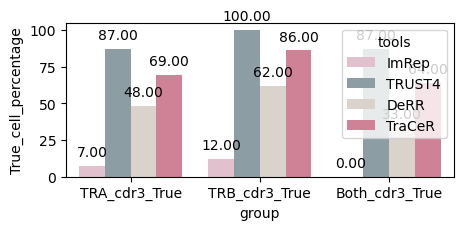

In [116]:
CDR3_AA_stat_150_df=CDR3_AA_stat_df[(CDR3_AA_stat_df.reads_length==150)
                                    &(CDR3_AA_stat_df.tools!='MiXCR')
                                    &(CDR3_AA_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_150_df, 
            x="group", y="True_cell_percentage",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_True_cell_percentage_readslength150.pdf")

In [117]:
CDR3_AA_stat_df['reads_length']=CDR3_AA_stat_df['reads_length'].astype(str)

In [118]:
CDR3_AA_stat_df['reads_length']= pd.Categorical(CDR3_AA_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

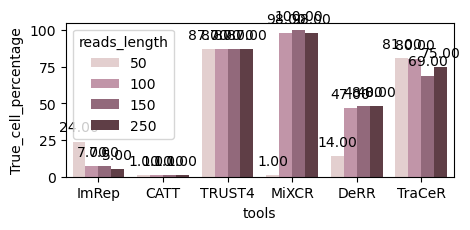

In [119]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="TRA_cdr3_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_True_cell_percentage_Achain.pdf")

<Figure size 512x384 with 0 Axes>

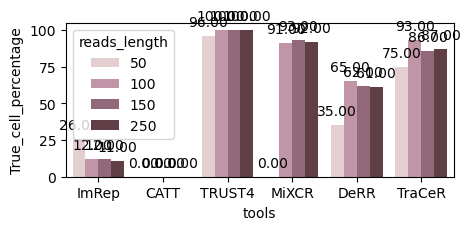

In [120]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="TRB_cdr3_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_True_cell_percentage_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

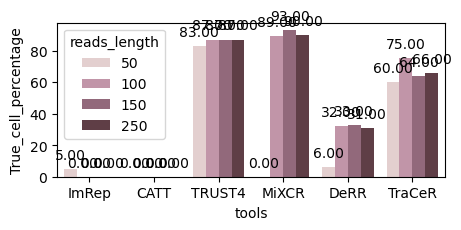

In [121]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="Both_cdr3_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_True_cell_percentage_Bothchain.pdf")

### V gene

In [122]:
Vgene_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_number>=1)[0])
        TRB_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_number>=1)[0])
        TRA_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_truenumber>=1)[0])
        TRB_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_truenumber>=1)[0])
        TRA_Vgene_cellnumber=len(TRA_Vgene_cellindex_list)
        TRB_Vgene_cellnumber=len(TRB_Vgene_cellindex_list)
        Both_Vgene_cellnumber=len(set(TRA_Vgene_cellindex_list).intersection(TRB_Vgene_cellindex_list))
        TRA_Vgene_True_cellnumber=len(TRA_Vgene_True_cellindex_list)
        TRB_Vgene_True_cellnumber=len(TRB_Vgene_True_cellindex_list)
        Both_Vgene_True_cellnumber=len(set(TRA_Vgene_True_cellindex_list).intersection(TRB_Vgene_True_cellindex_list))
        Vgene_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_Vgene_True','TRB_Vgene_True','Both_Vgene_True'],
                'True_cell_number':[TRA_Vgene_True_cellnumber,TRB_Vgene_True_cellnumber,Both_Vgene_True_cellnumber],
                'cell_number':[TRA_Vgene_cellnumber,TRB_Vgene_cellnumber,Both_Vgene_cellnumber]
            })
        Vgene_stat_tpm_df['reads_length']=i
        Vgene_stat_tpm_df['tools']=tools
        #Vgene_stat_tpm_df['sample_name']=sample_name
        Vgene_stat_tpm_df['total_cell_number']=total_cell_number
        Vgene_stat_tpm_df['True_cell_percentage']=(Vgene_stat_tpm_df['True_cell_number']/Vgene_stat_tpm_df['total_cell_number'])*100
        Vgene_stat_tpm_df['sensitivity']=(Vgene_stat_tpm_df['True_cell_number']/Vgene_stat_tpm_df['cell_number'])*100        
        #Vgene_stat_tpm_join_df=Vgene_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        Vgene_stat_df=Vgene_stat_df.append(Vgene_stat_tpm_df)

In [123]:
software="mixcr"
tmp_df=pd.read_csv("./Simulation_results/data/"+software+"_results_length.csv",index_col=0)

<Figure size 512x384 with 0 Axes>

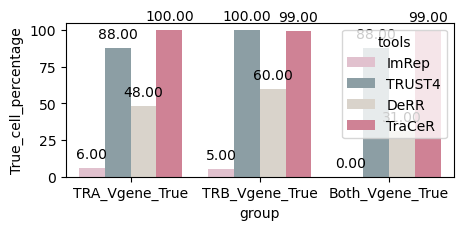

In [124]:
Vgene_stat_150_df=Vgene_stat_df[(Vgene_stat_df.reads_length==150)
                                    &(Vgene_stat_df.tools!='MiXCR')
                                    &(Vgene_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_150_df, 
            x="group", y="True_cell_percentage",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_True_cell_percentage_readslength150.pdf")

In [125]:
Vgene_stat_df['reads_length']=Vgene_stat_df['reads_length'].astype(str)

In [126]:
Vgene_stat_df['reads_length']= pd.Categorical(Vgene_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

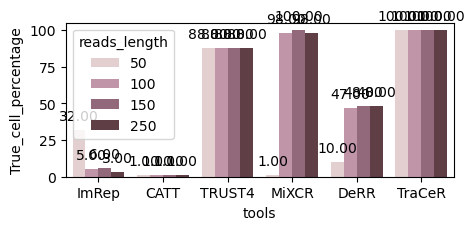

In [127]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="TRA_Vgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_True_cell_percentage_Achain.pdf")

<Figure size 512x384 with 0 Axes>

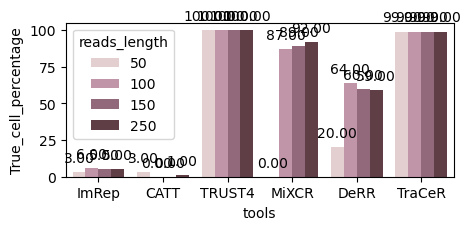

In [128]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="TRB_Vgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_True_cell_percentage_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

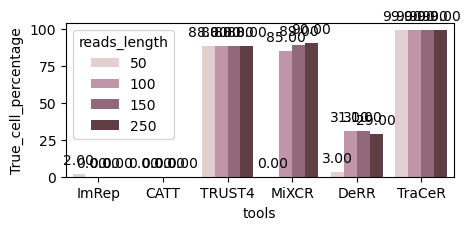

In [129]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="Both_Vgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_True_cell_percentage_Bothchain.pdf")

### J gene

In [130]:
Jgene_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_number>=1)[0])
        TRB_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_number>=1)[0])
        TRA_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_truenumber>=1)[0])
        TRB_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_truenumber>=1)[0])
        TRA_Jgene_cellnumber=len(TRA_Jgene_cellindex_list)
        TRB_Jgene_cellnumber=len(TRB_Jgene_cellindex_list)
        Both_Jgene_cellnumber=len(set(TRA_Jgene_cellindex_list).intersection(TRB_Jgene_cellindex_list))
        TRA_Jgene_True_cellnumber=len(TRA_Jgene_True_cellindex_list)
        TRB_Jgene_True_cellnumber=len(TRB_Jgene_True_cellindex_list)
        Both_Jgene_True_cellnumber=len(set(TRA_Jgene_True_cellindex_list).intersection(TRB_Jgene_True_cellindex_list))
        Jgene_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_Jgene_True','TRB_Jgene_True','Both_Jgene_True'],
                'True_cell_number':[TRA_Jgene_True_cellnumber,TRB_Jgene_True_cellnumber,Both_Jgene_True_cellnumber],
                'cell_number':[TRA_Jgene_cellnumber,TRB_Jgene_cellnumber,Both_Jgene_cellnumber]
            })
        Jgene_stat_tpm_df['reads_length']=i
        Jgene_stat_tpm_df['tools']=tools
        #Jgene_stat_tpm_df['sample_name']=sample_name
        Jgene_stat_tpm_df['total_cell_number']=total_cell_number
        Jgene_stat_tpm_df['True_cell_percentage']=(Jgene_stat_tpm_df['True_cell_number']/Jgene_stat_tpm_df['total_cell_number'])*100
        Jgene_stat_tpm_df['sensitivity']=(Jgene_stat_tpm_df['True_cell_number']/Jgene_stat_tpm_df['cell_number'])*100        
        #Jgene_stat_tpm_join_df=Jgene_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        Jgene_stat_df=Jgene_stat_df.append(Jgene_stat_tpm_df)

<Figure size 512x384 with 0 Axes>

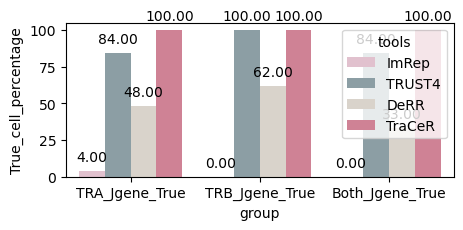

In [131]:
Jgene_stat_150_df=Jgene_stat_df[(Jgene_stat_df.reads_length==150)
                                    &(Jgene_stat_df.tools!='MiXCR')
                                    &(Jgene_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_150_df, 
            x="group", y="True_cell_percentage",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_True_cell_percentage_readslength150.pdf")

In [132]:
Jgene_stat_df['reads_length']=Jgene_stat_df['reads_length'].astype(str)

In [133]:
Jgene_stat_df['reads_length']= pd.Categorical(Jgene_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

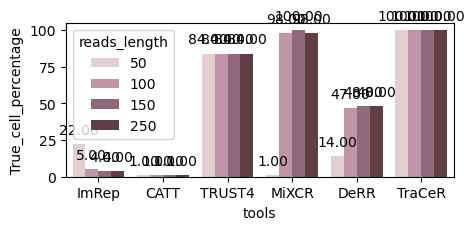

In [134]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="TRA_Jgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_True_cell_percentage_Achain.pdf")

<Figure size 512x384 with 0 Axes>

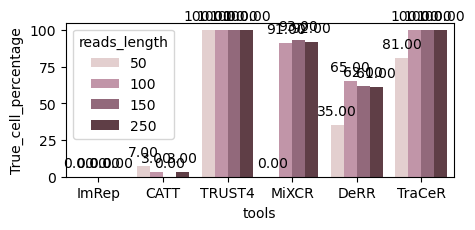

In [135]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="TRB_Jgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_True_cell_percentage_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

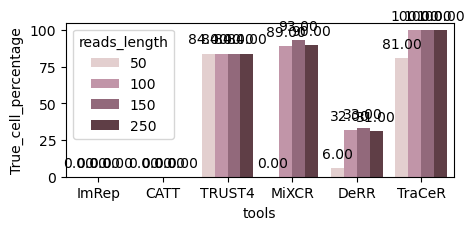

In [136]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="Both_Jgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_True_cell_percentage_Bothchain.pdf")

### Full length

In [137]:
fullTCR_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_number>=1)[0])
        TRB_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_number>=1)[0])
        TRA_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_truenumber>=1)[0])
        TRB_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_truenumber>=1)[0])
        TRA_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRA_CDR3_number>=1)[0])
        TRB_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRB_CDR3_number>=1)[0])
        TRA_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_cdr3_aa_gene_truenumber>=1)[0])
        TRB_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_cdr3_aa_gene_truenumber>=1)[0])
        TRA_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_number>=1)[0])
        TRB_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_number>=1)[0])
        TRA_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_truenumber>=1)[0])
        TRB_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_truenumber>=1)[0])
        TRA_fullTCR_True_cellindex_list=set(TRA_cdr3_True_cellindex_list).intersection(TRA_Vgene_True_cellindex_list).intersection(TRA_Jgene_True_cellindex_list)
        TRB_fullTCR_True_cellindex_list=set(TRB_cdr3_True_cellindex_list).intersection(TRB_Vgene_True_cellindex_list).intersection(TRB_Jgene_True_cellindex_list)        
        TRA_fullTCR_True_cellnumber=len(TRA_fullTCR_True_cellindex_list)
        TRB_fullTCR_True_cellnumber=len(TRB_fullTCR_True_cellindex_list)
        Both_fullTCR_True_cellnumber=len(set(TRA_fullTCR_True_cellindex_list).intersection(TRB_fullTCR_True_cellindex_list))
        TRA_fullTCR_cellindex_list=set(TRA_cdr3_cellindex_list).intersection(TRA_Vgene_cellindex_list).intersection(TRA_Jgene_cellindex_list)
        TRB_fullTCR_cellindex_list=set(TRB_cdr3_cellindex_list).intersection(TRB_Vgene_cellindex_list).intersection(TRB_Jgene_cellindex_list)        
        TRA_fullTCR_cellnumber=len(TRA_fullTCR_cellindex_list)
        TRB_fullTCR_cellnumber=len(TRB_fullTCR_cellindex_list)
        Both_fullTCR_cellnumber=len(set(TRA_fullTCR_cellindex_list).intersection(TRB_fullTCR_cellindex_list))        
        fullTCR_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_fullTCR_True','TRB_fullTCR_True','Both_fullTCR_True'],
                'True_cell_number':[TRA_fullTCR_True_cellnumber,TRB_fullTCR_True_cellnumber,Both_fullTCR_True_cellnumber],
                'cell_number':[TRA_fullTCR_cellnumber,TRB_fullTCR_cellnumber,Both_fullTCR_cellnumber]
            })
        fullTCR_stat_tpm_df['reads_length']=i
        fullTCR_stat_tpm_df['tools']=tools
        #fullTCR_stat_tpm_df['sample_name']=sample_name
        fullTCR_stat_tpm_df['total_cell_number']=total_cell_number
        fullTCR_stat_tpm_df['True_cell_percentage']=(fullTCR_stat_tpm_df['True_cell_number']/fullTCR_stat_tpm_df['total_cell_number'])*100
        fullTCR_stat_tpm_df['sensitivity']=(fullTCR_stat_tpm_df['True_cell_number']/fullTCR_stat_tpm_df['cell_number'])*100        
        #fullTCR_stat_tpm_join_df=fullTCR_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        fullTCR_stat_df=fullTCR_stat_df.append(fullTCR_stat_tpm_df)
        

<Figure size 512x384 with 0 Axes>

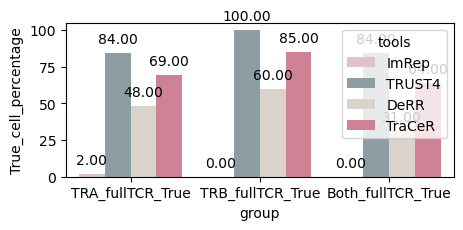

In [138]:
fullTCR_stat_150_df=fullTCR_stat_df[(fullTCR_stat_df.reads_length==150)
                                    &(fullTCR_stat_df.tools!='MiXCR')
                                    &(fullTCR_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_150_df, 
            x="group", y="True_cell_percentage",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_True_cell_percentage_readslength150.pdf")

In [139]:
fullTCR_stat_df['reads_length']=fullTCR_stat_df['reads_length'].astype(str)

In [140]:
fullTCR_stat_df['reads_length']= pd.Categorical(fullTCR_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

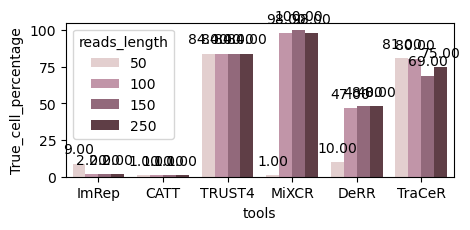

In [141]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="TRA_fullTCR_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_True_cell_percentage_Achain.pdf")

<Figure size 512x384 with 0 Axes>

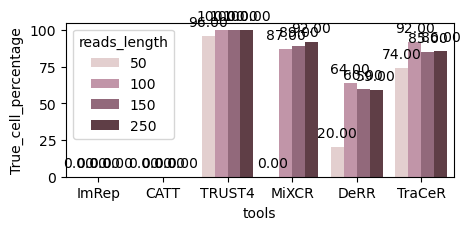

In [142]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="TRB_fullTCR_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_True_cell_percentage_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

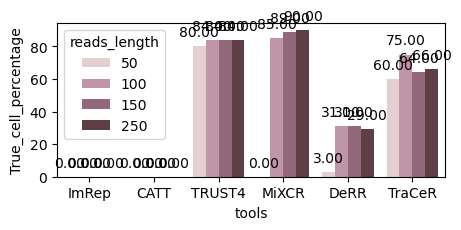

In [143]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="Both_fullTCR_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_True_cell_percentage_Bothchain.pdf")

## For different depth

In [144]:
stat_df=pd.DataFrame()
for software in software_ls:
    tmp_df=pd.read_csv("./Simulation_results/data/"+software+"_results_depth.csv",index_col=0)
    stat_df=stat_df.append(tmp_df)

In [145]:
stat_df.to_csv("./Simulation_results/data/all_software_results_depth.csv")

In [146]:
stat_df=pd.read_csv("./Simulation_results/data/all_software_results_depth.csv")

### CDR3

In [173]:
CDR3_AA_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_depth)):
    stat_filter_df=stat_df[stat_df.reads_depth==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRA_CDR3_number>=1)[0])
        TRB_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRB_CDR3_number>=1)[0])
        TRA_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_cdr3_aa_gene_truenumber>=1)[0])
        TRB_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_cdr3_aa_gene_truenumber>=1)[0])
        TRA_cdr3_cellnumber=len(TRA_cdr3_cellindex_list)
        TRB_cdr3_cellnumber=len(TRB_cdr3_cellindex_list)
        Both_cdr3_cellnumber=len(set(TRA_cdr3_cellindex_list).intersection(TRB_cdr3_cellindex_list))
        TRA_cdr3_True_cellnumber=len(TRA_cdr3_True_cellindex_list)
        TRB_cdr3_True_cellnumber=len(TRB_cdr3_True_cellindex_list)
        Both_cdr3_True_cellnumber=len(set(TRA_cdr3_True_cellindex_list).intersection(TRB_cdr3_True_cellindex_list))
        CDR3_AA_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_cdr3_True','TRB_cdr3_True','Both_cdr3_True'],
                'True_cell_number':[TRA_cdr3_True_cellnumber,TRB_cdr3_True_cellnumber,Both_cdr3_True_cellnumber],
                'cell_number':[TRA_cdr3_cellnumber,TRB_cdr3_cellnumber,Both_cdr3_cellnumber]
            })
        CDR3_AA_stat_tpm_df['reads_depth']=i
        CDR3_AA_stat_tpm_df['tools']=tools
        #CDR3_AA_stat_tpm_df['sample_name']=sample_name
        CDR3_AA_stat_tpm_df['total_cell_number']=total_cell_number
        CDR3_AA_stat_tpm_df['True_cell_percentage']=(CDR3_AA_stat_tpm_df['True_cell_number']/CDR3_AA_stat_tpm_df['total_cell_number'])*100
        CDR3_AA_stat_tpm_df['sensitivity']=(CDR3_AA_stat_tpm_df['True_cell_number']/CDR3_AA_stat_tpm_df['cell_number'])*100        
        #CDR3_AA_stat_tpm_join_df=CDR3_AA_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        CDR3_AA_stat_df=CDR3_AA_stat_df.append(CDR3_AA_stat_tpm_df)

In [176]:
CDR3_AA_stat_df['reads_depth']=CDR3_AA_stat_df['reads_depth'].astype(int).astype(str)

In [178]:
CDR3_AA_stat_df['reads_depth']= pd.Categorical(CDR3_AA_stat_df['reads_depth'], 
                                                categories=['2', '4', '6','8','10',
                                                            '20','40','60','80','100'])

<Figure size 512x384 with 0 Axes>

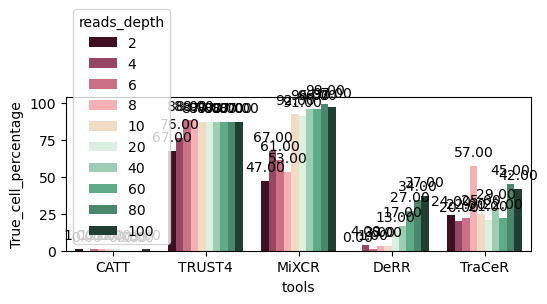

In [180]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(6,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="TRA_cdr3_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_True_cell_percentage_Achain_depth.pdf")

<Figure size 512x384 with 0 Axes>

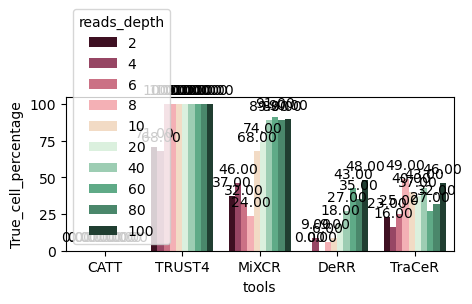

In [181]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="TRB_cdr3_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_True_cell_percentage_Bchain_depth.pdf")

<Figure size 512x384 with 0 Axes>

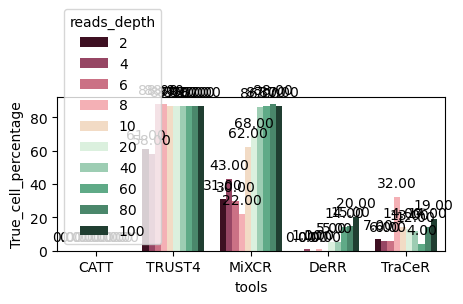

In [182]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="Both_cdr3_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_True_cell_percentage_Bothchain_depth.pdf")

### V gene

In [183]:
Vgene_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_depth)):
    stat_filter_df=stat_df[stat_df.reads_depth==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_number>=1)[0])
        TRB_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_number>=1)[0])
        TRA_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_truenumber>=1)[0])
        TRB_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_truenumber>=1)[0])
        TRA_Vgene_cellnumber=len(TRA_Vgene_cellindex_list)
        TRB_Vgene_cellnumber=len(TRB_Vgene_cellindex_list)
        Both_Vgene_cellnumber=len(set(TRA_Vgene_cellindex_list).intersection(TRB_Vgene_cellindex_list))
        TRA_Vgene_True_cellnumber=len(TRA_Vgene_True_cellindex_list)
        TRB_Vgene_True_cellnumber=len(TRB_Vgene_True_cellindex_list)
        Both_Vgene_True_cellnumber=len(set(TRA_Vgene_True_cellindex_list).intersection(TRB_Vgene_True_cellindex_list))
        Vgene_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_Vgene_True','TRB_Vgene_True','Both_Vgene_True'],
                'True_cell_number':[TRA_Vgene_True_cellnumber,TRB_Vgene_True_cellnumber,Both_Vgene_True_cellnumber],
                'cell_number':[TRA_Vgene_cellnumber,TRB_Vgene_cellnumber,Both_Vgene_cellnumber]
            })
        Vgene_stat_tpm_df['reads_depth']=i
        Vgene_stat_tpm_df['tools']=tools
        #Vgene_stat_tpm_df['sample_name']=sample_name
        Vgene_stat_tpm_df['total_cell_number']=total_cell_number
        Vgene_stat_tpm_df['True_cell_percentage']=(Vgene_stat_tpm_df['True_cell_number']/Vgene_stat_tpm_df['total_cell_number'])*100
        Vgene_stat_tpm_df['sensitivity']=(Vgene_stat_tpm_df['True_cell_number']/Vgene_stat_tpm_df['cell_number'])*100        
        #Vgene_stat_tpm_join_df=Vgene_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        Vgene_stat_df=Vgene_stat_df.append(Vgene_stat_tpm_df)

In [184]:
software="mixcr"
tmp_df=pd.read_csv("./Simulation_results/data/"+software+"_results_depth.csv",index_col=0)

In [185]:
Vgene_stat_df['reads_depth']=Vgene_stat_df['reads_depth'].astype(int).astype(str)

In [186]:
Vgene_stat_df['reads_depth']= pd.Categorical(Vgene_stat_df['reads_depth'], 
                                                categories=['2', '4', '6','8','10',
                                                           '20','40','60','80','100'])

<Figure size 512x384 with 0 Axes>

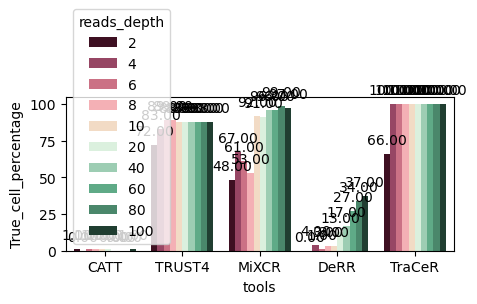

In [187]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="TRA_Vgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_True_cell_percentage_Achain_depth.pdf")

<Figure size 512x384 with 0 Axes>

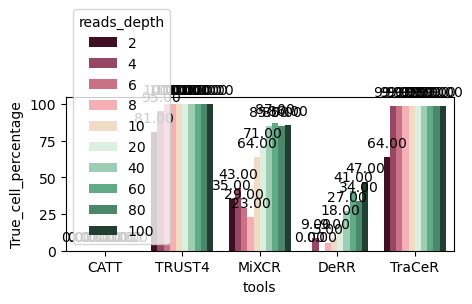

In [188]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="TRB_Vgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_True_cell_percentage_Bchain_depth.pdf")

<Figure size 512x384 with 0 Axes>

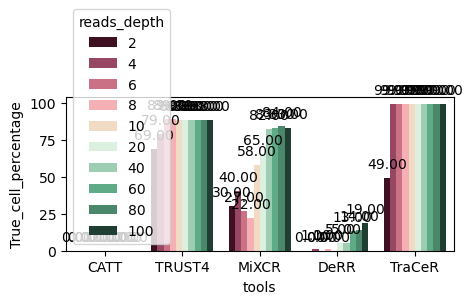

In [189]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="Both_Vgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_True_cell_percentage_Bothchain_depth.pdf")

### J gene

In [190]:
Jgene_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_depth)):
    stat_filter_df=stat_df[stat_df.reads_depth==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_number>=1)[0])
        TRB_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_number>=1)[0])
        TRA_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_truenumber>=1)[0])
        TRB_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_truenumber>=1)[0])
        TRA_Jgene_cellnumber=len(TRA_Jgene_cellindex_list)
        TRB_Jgene_cellnumber=len(TRB_Jgene_cellindex_list)
        Both_Jgene_cellnumber=len(set(TRA_Jgene_cellindex_list).intersection(TRB_Jgene_cellindex_list))
        TRA_Jgene_True_cellnumber=len(TRA_Jgene_True_cellindex_list)
        TRB_Jgene_True_cellnumber=len(TRB_Jgene_True_cellindex_list)
        Both_Jgene_True_cellnumber=len(set(TRA_Jgene_True_cellindex_list).intersection(TRB_Jgene_True_cellindex_list))
        Jgene_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_Jgene_True','TRB_Jgene_True','Both_Jgene_True'],
                'True_cell_number':[TRA_Jgene_True_cellnumber,TRB_Jgene_True_cellnumber,Both_Jgene_True_cellnumber],
                'cell_number':[TRA_Jgene_cellnumber,TRB_Jgene_cellnumber,Both_Jgene_cellnumber]
            })
        Jgene_stat_tpm_df['reads_depth']=i
        Jgene_stat_tpm_df['tools']=tools
        #Jgene_stat_tpm_df['sample_name']=sample_name
        Jgene_stat_tpm_df['total_cell_number']=total_cell_number
        Jgene_stat_tpm_df['True_cell_percentage']=(Jgene_stat_tpm_df['True_cell_number']/Jgene_stat_tpm_df['total_cell_number'])*100
        Jgene_stat_tpm_df['sensitivity']=(Jgene_stat_tpm_df['True_cell_number']/Jgene_stat_tpm_df['cell_number'])*100        
        #Jgene_stat_tpm_join_df=Jgene_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        Jgene_stat_df=Jgene_stat_df.append(Jgene_stat_tpm_df)

In [191]:
Jgene_stat_df['reads_depth']=Jgene_stat_df['reads_depth'].astype(int).astype(str)

In [192]:
Jgene_stat_df['reads_depth']= pd.Categorical(Jgene_stat_df['reads_depth'], 
                                                categories=['2', '4', '6','8','10',
                                                           '20','40','60','80','100'])

<Figure size 512x384 with 0 Axes>

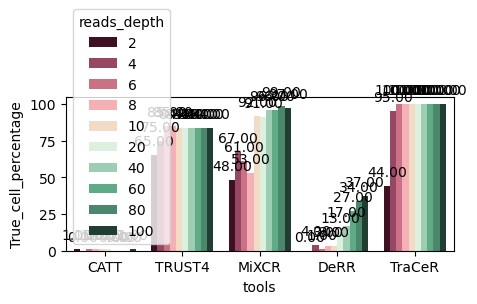

In [193]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="TRA_Jgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_True_cell_percentage_Achain_depth.pdf")

<Figure size 512x384 with 0 Axes>

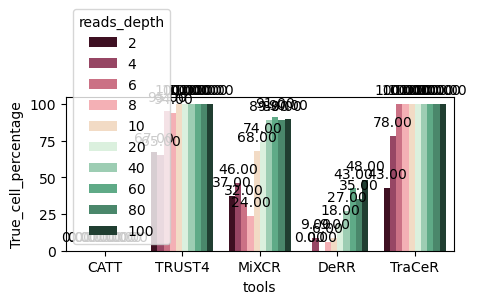

In [194]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="TRB_Jgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_True_cell_percentage_Bchain_depth.pdf")

<Figure size 512x384 with 0 Axes>

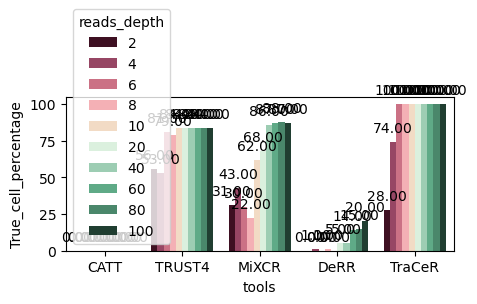

In [195]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="Both_Jgene_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_True_cell_percentage_Bothchain_depth.pdf")

### Full length

In [199]:
fullTCR_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_depth)):
    stat_filter_df=stat_df[stat_df.reads_depth==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_number>=1)[0])
        TRB_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_number>=1)[0])
        TRA_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_truenumber>=1)[0])
        TRB_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_truenumber>=1)[0])
        TRA_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRA_CDR3_number>=1)[0])
        TRB_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRB_CDR3_number>=1)[0])
        TRA_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_cdr3_aa_gene_truenumber>=1)[0])
        TRB_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_cdr3_aa_gene_truenumber>=1)[0])
        TRA_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_number>=1)[0])
        TRB_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_number>=1)[0])
        TRA_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_truenumber>=1)[0])
        TRB_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_truenumber>=1)[0])
        TRA_fullTCR_True_cellindex_list=set(TRA_cdr3_True_cellindex_list).intersection(TRA_Vgene_True_cellindex_list).intersection(TRA_Jgene_True_cellindex_list)
        TRB_fullTCR_True_cellindex_list=set(TRB_cdr3_True_cellindex_list).intersection(TRB_Vgene_True_cellindex_list).intersection(TRB_Jgene_True_cellindex_list)        
        TRA_fullTCR_True_cellnumber=len(TRA_fullTCR_True_cellindex_list)
        TRB_fullTCR_True_cellnumber=len(TRB_fullTCR_True_cellindex_list)
        Both_fullTCR_True_cellnumber=len(set(TRA_fullTCR_True_cellindex_list).intersection(TRB_fullTCR_True_cellindex_list))
        TRA_fullTCR_cellindex_list=set(TRA_cdr3_cellindex_list).intersection(TRA_Vgene_cellindex_list).intersection(TRA_Jgene_cellindex_list)
        TRB_fullTCR_cellindex_list=set(TRB_cdr3_cellindex_list).intersection(TRB_Vgene_cellindex_list).intersection(TRB_Jgene_cellindex_list)        
        TRA_fullTCR_cellnumber=len(TRA_fullTCR_cellindex_list)
        TRB_fullTCR_cellnumber=len(TRB_fullTCR_cellindex_list)
        Both_fullTCR_cellnumber=len(set(TRA_fullTCR_cellindex_list).intersection(TRB_fullTCR_cellindex_list))        
        fullTCR_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_fullTCR_True','TRB_fullTCR_True','Both_fullTCR_True'],
                'True_cell_number':[TRA_fullTCR_True_cellnumber,TRB_fullTCR_True_cellnumber,Both_fullTCR_True_cellnumber],
                'cell_number':[TRA_fullTCR_cellnumber,TRB_fullTCR_cellnumber,Both_fullTCR_cellnumber]
            })
        fullTCR_stat_tpm_df['reads_depth']=i
        fullTCR_stat_tpm_df['tools']=tools
        #fullTCR_stat_tpm_df['sample_name']=sample_name
        fullTCR_stat_tpm_df['total_cell_number']=total_cell_number
        fullTCR_stat_tpm_df['True_cell_percentage']=(fullTCR_stat_tpm_df['True_cell_number']/fullTCR_stat_tpm_df['total_cell_number'])*100
        fullTCR_stat_tpm_df['sensitivity']=(fullTCR_stat_tpm_df['True_cell_number']/fullTCR_stat_tpm_df['cell_number'])*100        
        #fullTCR_stat_tpm_join_df=fullTCR_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        fullTCR_stat_df=fullTCR_stat_df.append(fullTCR_stat_tpm_df)
        

In [200]:
fullTCR_stat_df['reads_depth']=fullTCR_stat_df['reads_depth'].astype(int).astype(str)

In [201]:
fullTCR_stat_df['reads_depth']= pd.Categorical(fullTCR_stat_df['reads_depth'], 
                                                categories=['2', '4', '6','8','10',
                                                           '20','40','60','80','100'])

<Figure size 512x384 with 0 Axes>

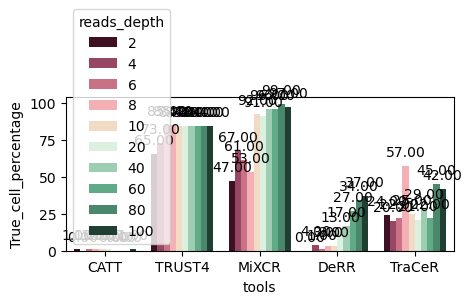

In [202]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="TRA_fullTCR_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_True_cell_percentage_Achain_depth.pdf")

<Figure size 512x384 with 0 Axes>

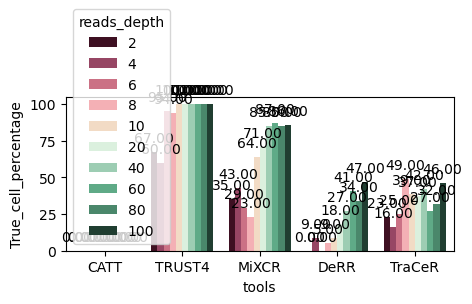

In [204]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="TRB_fullTCR_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_True_cell_percentage_Bchain_depth.pdf")

<Figure size 512x384 with 0 Axes>

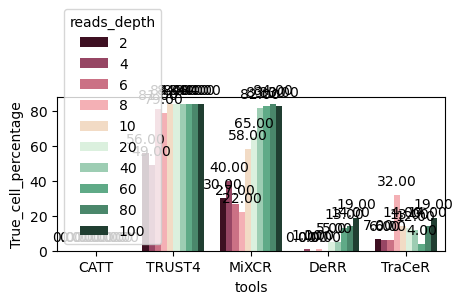

In [205]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="Both_fullTCR_True"], 
            x="tools", y="True_cell_percentage",
            hue="reads_depth",
            palette={
                '100':"#1b4332",
                '80':"#40916c",
                '60':"#52b788",
                '40':"#95d5b2",
                '20':"#d8f3dc",
                '10':"#f9dbbd",
                '8':"#ffa5ab",
                '6':"#da627d",
                '4':"#a53860",
                "2":"#450920"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_True_cell_percentage_Bothchain_depth.pdf")

# visualization for sensitivity

In [206]:
warnings.filterwarnings('ignore')
import seaborn as snsc
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [207]:
software_ls=['trust4','mixcr','tracer','imrep','catt','derr']

## For different length

In [208]:
stat_df=pd.DataFrame()
for software in software_ls:
    tmp_df=pd.read_csv("./Simulation_results/data/"+software+"_results_length.csv",index_col=0)
    stat_df=stat_df.append(tmp_df)

In [209]:
stat_df.to_csv("./Simulation_results/data/all_software_results_length.csv")

In [210]:
stat_df=pd.read_csv("./Simulation_results/data/all_software_results_length.csv")

### CDR3

In [211]:
CDR3_AA_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRA_CDR3_number>=1)[0])
        TRB_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRB_CDR3_number>=1)[0])
        TRA_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_cdr3_aa_gene_truenumber>=1)[0])
        TRB_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_cdr3_aa_gene_truenumber>=1)[0])
        TRA_cdr3_cellnumber=len(TRA_cdr3_cellindex_list)
        TRB_cdr3_cellnumber=len(TRB_cdr3_cellindex_list)
        Both_cdr3_cellnumber=len(set(TRA_cdr3_cellindex_list).intersection(TRB_cdr3_cellindex_list))
        TRA_cdr3_True_cellnumber=len(TRA_cdr3_True_cellindex_list)
        TRB_cdr3_True_cellnumber=len(TRB_cdr3_True_cellindex_list)
        Both_cdr3_True_cellnumber=len(set(TRA_cdr3_True_cellindex_list).intersection(TRB_cdr3_True_cellindex_list))
        CDR3_AA_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_cdr3_True','TRB_cdr3_True','Both_cdr3_True'],
                'True_cell_number':[TRA_cdr3_True_cellnumber,TRB_cdr3_True_cellnumber,Both_cdr3_True_cellnumber],
                'cell_number':[TRA_cdr3_cellnumber,TRB_cdr3_cellnumber,Both_cdr3_cellnumber]
            })
        CDR3_AA_stat_tpm_df['reads_length']=i
        CDR3_AA_stat_tpm_df['tools']=tools
        #CDR3_AA_stat_tpm_df['sample_name']=sample_name
        CDR3_AA_stat_tpm_df['total_cell_number']=total_cell_number
        CDR3_AA_stat_tpm_df['sensitivity']=(CDR3_AA_stat_tpm_df['True_cell_number']/CDR3_AA_stat_tpm_df['total_cell_number'])*100
        CDR3_AA_stat_tpm_df['sensitivity']=(CDR3_AA_stat_tpm_df['True_cell_number']/CDR3_AA_stat_tpm_df['cell_number'])*100        
        #CDR3_AA_stat_tpm_join_df=CDR3_AA_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        CDR3_AA_stat_df=CDR3_AA_stat_df.append(CDR3_AA_stat_tpm_df)

<Figure size 512x384 with 0 Axes>

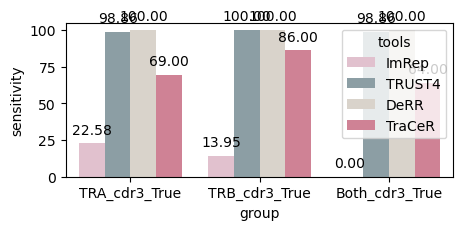

In [212]:
CDR3_AA_stat_150_df=CDR3_AA_stat_df[(CDR3_AA_stat_df.reads_length==150)
                                    &(CDR3_AA_stat_df.tools!='MiXCR')
                                    &(CDR3_AA_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_150_df, 
            x="group", y="sensitivity",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_sensitivity_readslength150.pdf")

In [213]:
CDR3_AA_stat_df['reads_length']=CDR3_AA_stat_df['reads_length'].astype(str)

In [214]:
CDR3_AA_stat_df['reads_length']= pd.Categorical(CDR3_AA_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

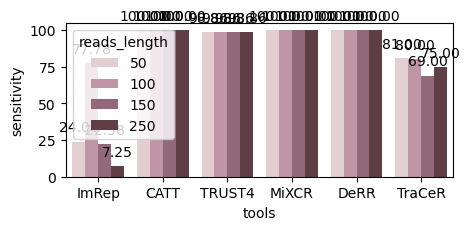

In [215]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="TRA_cdr3_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_sensitivity_Achain.pdf")

<Figure size 512x384 with 0 Axes>

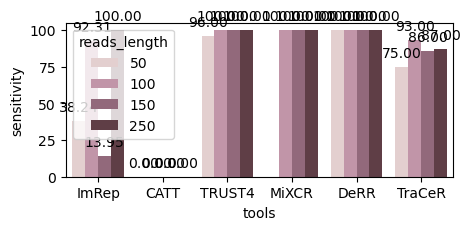

In [216]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="TRB_cdr3_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_sensitivity_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

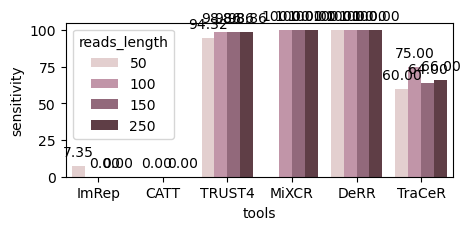

In [217]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=CDR3_AA_stat_df[CDR3_AA_stat_df.group=="Both_cdr3_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/CDR3_sensitivity_Bothchain.pdf")

### V gene

In [218]:
Vgene_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_number>=1)[0])
        TRB_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_number>=1)[0])
        TRA_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_truenumber>=1)[0])
        TRB_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_truenumber>=1)[0])
        TRA_Vgene_cellnumber=len(TRA_Vgene_cellindex_list)
        TRB_Vgene_cellnumber=len(TRB_Vgene_cellindex_list)
        Both_Vgene_cellnumber=len(set(TRA_Vgene_cellindex_list).intersection(TRB_Vgene_cellindex_list))
        TRA_Vgene_True_cellnumber=len(TRA_Vgene_True_cellindex_list)
        TRB_Vgene_True_cellnumber=len(TRB_Vgene_True_cellindex_list)
        Both_Vgene_True_cellnumber=len(set(TRA_Vgene_True_cellindex_list).intersection(TRB_Vgene_True_cellindex_list))
        Vgene_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_Vgene_True','TRB_Vgene_True','Both_Vgene_True'],
                'True_cell_number':[TRA_Vgene_True_cellnumber,TRB_Vgene_True_cellnumber,Both_Vgene_True_cellnumber],
                'cell_number':[TRA_Vgene_cellnumber,TRB_Vgene_cellnumber,Both_Vgene_cellnumber]
            })
        Vgene_stat_tpm_df['reads_length']=i
        Vgene_stat_tpm_df['tools']=tools
        #Vgene_stat_tpm_df['sample_name']=sample_name
        Vgene_stat_tpm_df['total_cell_number']=total_cell_number
        Vgene_stat_tpm_df['sensitivity']=(Vgene_stat_tpm_df['True_cell_number']/Vgene_stat_tpm_df['total_cell_number'])*100
        Vgene_stat_tpm_df['sensitivity']=(Vgene_stat_tpm_df['True_cell_number']/Vgene_stat_tpm_df['cell_number'])*100        
        #Vgene_stat_tpm_join_df=Vgene_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        Vgene_stat_df=Vgene_stat_df.append(Vgene_stat_tpm_df)

In [219]:
software="mixcr"
tmp_df=pd.read_csv("./Simulation_results/data/"+software+"_results_length.csv",index_col=0)

<Figure size 512x384 with 0 Axes>

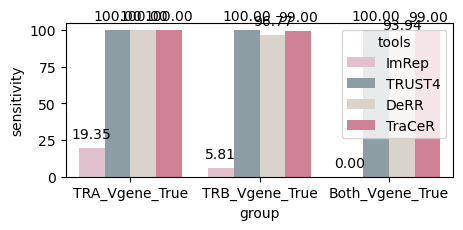

In [220]:
Vgene_stat_150_df=Vgene_stat_df[(Vgene_stat_df.reads_length==150)
                                    &(Vgene_stat_df.tools!='MiXCR')
                                    &(Vgene_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_150_df, 
            x="group", y="sensitivity",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_sensitivity_readslength150.pdf")

In [221]:
Vgene_stat_df['reads_length']=Vgene_stat_df['reads_length'].astype(str)

In [222]:
Vgene_stat_df['reads_length']= pd.Categorical(Vgene_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

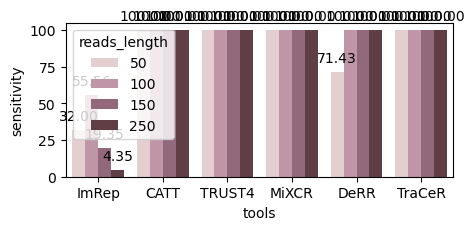

In [223]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="TRA_Vgene_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_sensitivity_Achain.pdf")

<Figure size 512x384 with 0 Axes>

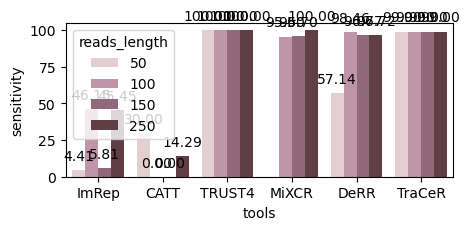

In [224]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="TRB_Vgene_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_sensitivity_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

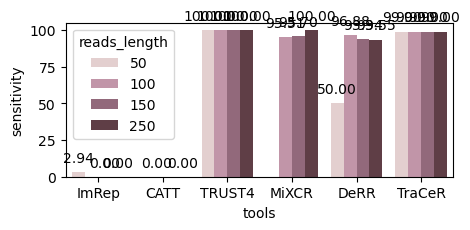

In [225]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Vgene_stat_df[Vgene_stat_df.group=="Both_Vgene_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Vgene_sensitivity_Bothchain.pdf")

### J gene

In [226]:
Jgene_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_number>=1)[0])
        TRB_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_number>=1)[0])
        TRA_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_truenumber>=1)[0])
        TRB_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_truenumber>=1)[0])
        TRA_Jgene_cellnumber=len(TRA_Jgene_cellindex_list)
        TRB_Jgene_cellnumber=len(TRB_Jgene_cellindex_list)
        Both_Jgene_cellnumber=len(set(TRA_Jgene_cellindex_list).intersection(TRB_Jgene_cellindex_list))
        TRA_Jgene_True_cellnumber=len(TRA_Jgene_True_cellindex_list)
        TRB_Jgene_True_cellnumber=len(TRB_Jgene_True_cellindex_list)
        Both_Jgene_True_cellnumber=len(set(TRA_Jgene_True_cellindex_list).intersection(TRB_Jgene_True_cellindex_list))
        Jgene_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_Jgene_True','TRB_Jgene_True','Both_Jgene_True'],
                'True_cell_number':[TRA_Jgene_True_cellnumber,TRB_Jgene_True_cellnumber,Both_Jgene_True_cellnumber],
                'cell_number':[TRA_Jgene_cellnumber,TRB_Jgene_cellnumber,Both_Jgene_cellnumber]
            })
        Jgene_stat_tpm_df['reads_length']=i
        Jgene_stat_tpm_df['tools']=tools
        #Jgene_stat_tpm_df['sample_name']=sample_name
        Jgene_stat_tpm_df['total_cell_number']=total_cell_number
        Jgene_stat_tpm_df['sensitivity']=(Jgene_stat_tpm_df['True_cell_number']/Jgene_stat_tpm_df['total_cell_number'])*100
        Jgene_stat_tpm_df['sensitivity']=(Jgene_stat_tpm_df['True_cell_number']/Jgene_stat_tpm_df['cell_number'])*100        
        #Jgene_stat_tpm_join_df=Jgene_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        Jgene_stat_df=Jgene_stat_df.append(Jgene_stat_tpm_df)

<Figure size 512x384 with 0 Axes>

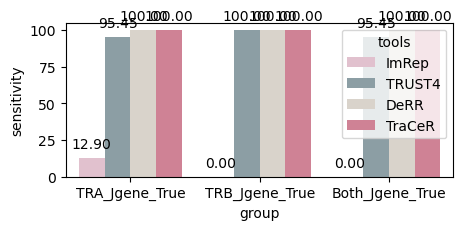

In [227]:
Jgene_stat_150_df=Jgene_stat_df[(Jgene_stat_df.reads_length==150)
                                    &(Jgene_stat_df.tools!='MiXCR')
                                    &(Jgene_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_150_df, 
            x="group", y="sensitivity",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_sensitivity_readslength150.pdf")

In [228]:
Jgene_stat_df['reads_length']=Jgene_stat_df['reads_length'].astype(str)

In [229]:
Jgene_stat_df['reads_length']= pd.Categorical(Jgene_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

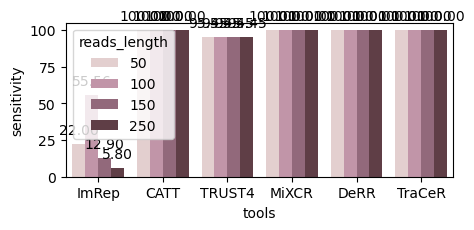

In [230]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="TRA_Jgene_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_sensitivity_Achain.pdf")

<Figure size 512x384 with 0 Axes>

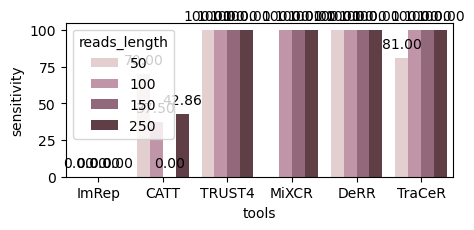

In [231]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="TRB_Jgene_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_sensitivity_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

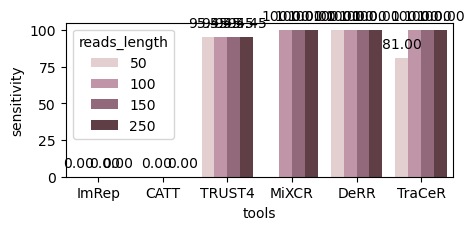

In [232]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=Jgene_stat_df[Jgene_stat_df.group=="Both_Jgene_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/Jgene_sensitivity_Bothchain.pdf")

### Full length

In [233]:
fullTCR_stat_df=pd.DataFrame()
for i in list(set(stat_df.reads_length)):
    stat_filter_df=stat_df[stat_df.reads_length==i]
    tools_list=list(set(stat_filter_df.tools.values))
    for tools in tools_list:
        stat_df_tmp=stat_filter_df[stat_filter_df.tools==tools]
        total_cell_number=len(set(stat_df_tmp.index))
        TRA_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_number>=1)[0])
        TRB_Vgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_number>=1)[0])
        TRA_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_V_gene_truenumber>=1)[0])
        TRB_Vgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_V_gene_truenumber>=1)[0])
        TRA_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRA_CDR3_number>=1)[0])
        TRB_cdr3_cellindex_list=list(np.where(
            stat_df_tmp.TRB_CDR3_number>=1)[0])
        TRA_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_cdr3_aa_gene_truenumber>=1)[0])
        TRB_cdr3_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_cdr3_aa_gene_truenumber>=1)[0])
        TRA_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_number>=1)[0])
        TRB_Jgene_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_number>=1)[0])
        TRA_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRA_J_gene_truenumber>=1)[0])
        TRB_Jgene_True_cellindex_list=list(np.where(
            stat_df_tmp.TRB_J_gene_truenumber>=1)[0])
        TRA_fullTCR_True_cellindex_list=set(TRA_cdr3_True_cellindex_list).intersection(TRA_Vgene_True_cellindex_list).intersection(TRA_Jgene_True_cellindex_list)
        TRB_fullTCR_True_cellindex_list=set(TRB_cdr3_True_cellindex_list).intersection(TRB_Vgene_True_cellindex_list).intersection(TRB_Jgene_True_cellindex_list)        
        TRA_fullTCR_True_cellnumber=len(TRA_fullTCR_True_cellindex_list)
        TRB_fullTCR_True_cellnumber=len(TRB_fullTCR_True_cellindex_list)
        Both_fullTCR_True_cellnumber=len(set(TRA_fullTCR_True_cellindex_list).intersection(TRB_fullTCR_True_cellindex_list))
        TRA_fullTCR_cellindex_list=set(TRA_cdr3_cellindex_list).intersection(TRA_Vgene_cellindex_list).intersection(TRA_Jgene_cellindex_list)
        TRB_fullTCR_cellindex_list=set(TRB_cdr3_cellindex_list).intersection(TRB_Vgene_cellindex_list).intersection(TRB_Jgene_cellindex_list)        
        TRA_fullTCR_cellnumber=len(TRA_fullTCR_cellindex_list)
        TRB_fullTCR_cellnumber=len(TRB_fullTCR_cellindex_list)
        Both_fullTCR_cellnumber=len(set(TRA_fullTCR_cellindex_list).intersection(TRB_fullTCR_cellindex_list))        
        fullTCR_stat_tpm_df=pd.DataFrame(
            {
                'group':['TRA_fullTCR_True','TRB_fullTCR_True','Both_fullTCR_True'],
                'True_cell_number':[TRA_fullTCR_True_cellnumber,TRB_fullTCR_True_cellnumber,Both_fullTCR_True_cellnumber],
                'cell_number':[TRA_fullTCR_cellnumber,TRB_fullTCR_cellnumber,Both_fullTCR_cellnumber]
            })
        fullTCR_stat_tpm_df['reads_length']=i
        fullTCR_stat_tpm_df['tools']=tools
        #fullTCR_stat_tpm_df['sample_name']=sample_name
        fullTCR_stat_tpm_df['total_cell_number']=total_cell_number
        fullTCR_stat_tpm_df['sensitivity']=(fullTCR_stat_tpm_df['True_cell_number']/fullTCR_stat_tpm_df['total_cell_number'])*100
        fullTCR_stat_tpm_df['sensitivity']=(fullTCR_stat_tpm_df['True_cell_number']/fullTCR_stat_tpm_df['cell_number'])*100        
        #fullTCR_stat_tpm_join_df=fullTCR_stat_tpm_df.join(sample_info_df.set_index('sample_name'),on='sample_name')
        fullTCR_stat_df=fullTCR_stat_df.append(fullTCR_stat_tpm_df)
        

<Figure size 512x384 with 0 Axes>

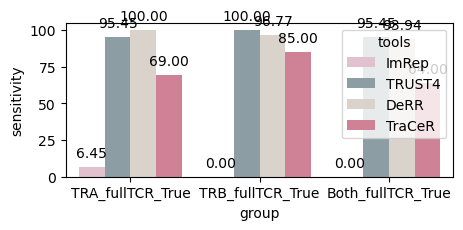

In [234]:
fullTCR_stat_150_df=fullTCR_stat_df[(fullTCR_stat_df.reads_length==150)
                                    &(fullTCR_stat_df.tools!='MiXCR')
                                    &(fullTCR_stat_df.tools!='CATT')]
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_150_df, 
            x="group", y="sensitivity",
            hue="tools",
           palette={
               'TraCeR':'#dc758f',
               'TRUST4':'#88a0a8',
               'ImRep':'#e6bccd',
               'DeRR':'#dbd3c9'
           })
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_sensitivity_readslength150.pdf")

In [235]:
fullTCR_stat_df['reads_length']=fullTCR_stat_df['reads_length'].astype(str)

In [236]:
fullTCR_stat_df['reads_length']= pd.Categorical(fullTCR_stat_df['reads_length'], 
                                                categories=['50', '100', '150','250'])

<Figure size 512x384 with 0 Axes>

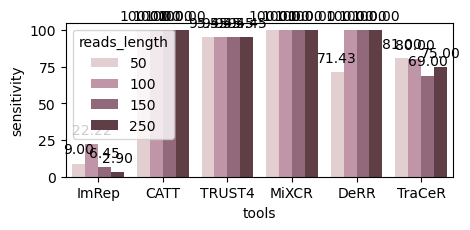

In [237]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="TRA_fullTCR_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_sensitivity_Achain.pdf")

<Figure size 512x384 with 0 Axes>

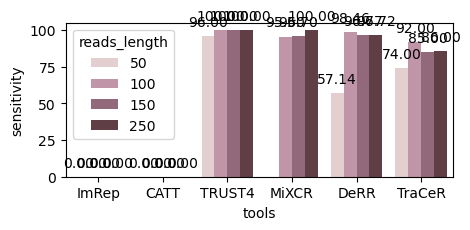

In [238]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="TRB_fullTCR_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_sensitivity_Bchain.pdf")

<Figure size 512x384 with 0 Axes>

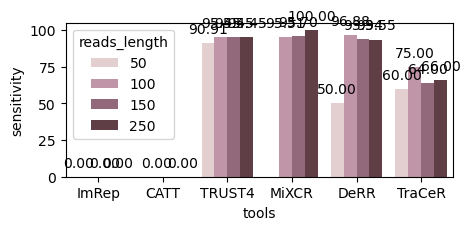

In [239]:
plt.figure(dpi=80)
#sns.set(style="white")
fig,ax=plt.subplots()
fig.set_size_inches(5,2)
ax=sns.barplot(data=fullTCR_stat_df[fullTCR_stat_df.group=="Both_fullTCR_True"], 
            x="tools", y="sensitivity",
            hue="reads_length",
            palette={
                '250':"#643843",
                '150':"#99627A",
                '100':"#C88EA7",
                "50":"#E7CBCB"
                
            }
              )
# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.savefig("./Visualization_results/fullTCR_sensitivity_Bothchain.pdf")